# Importing Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
rcParams['axes.labelpad'] = 20 
rcParams['axes.titlesize'] = 20
rcParams['axes.titlepad'] = 20 
rcParams['figure.figsize'] = 22, 10
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# Data Input and Exploration

In [ ]:
file_url = '/content/drive/MyDrive/Data Klorofil-a dan SST di Selat Bali Tahun 2003 - 2020.csv'

In [ ]:
df = pd.read_csv(
  file_url, 
  parse_dates=['Date'], 
  index_col="Date"
)
df_date = pd.read_csv(
    file_url,
    parse_dates=['Date']
)

In [ ]:
df.shape

(6575, 2)

In [ ]:
df

,Chl_a,SST
Date,,
2003-01-01,0.516417,26.484464
2003-01-02,0.516417,26.035000
2003-01-03,0.587642,26.108195
2003-01-04,0.409903,26.417035
2003-01-05,0.193843,26.686748
...,...,...
2020-12-27,1.711176,28.482039
2020-12-28,1.711176,26.014872
2020-12-29,0.634833,27.252737


In [ ]:
df['day_of_month'] = df.index.day
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month

Text(0.5, 1.0, 'Konsentrasi Klorofil-a di Selat Bali pada Tahun 2003 - 2020')

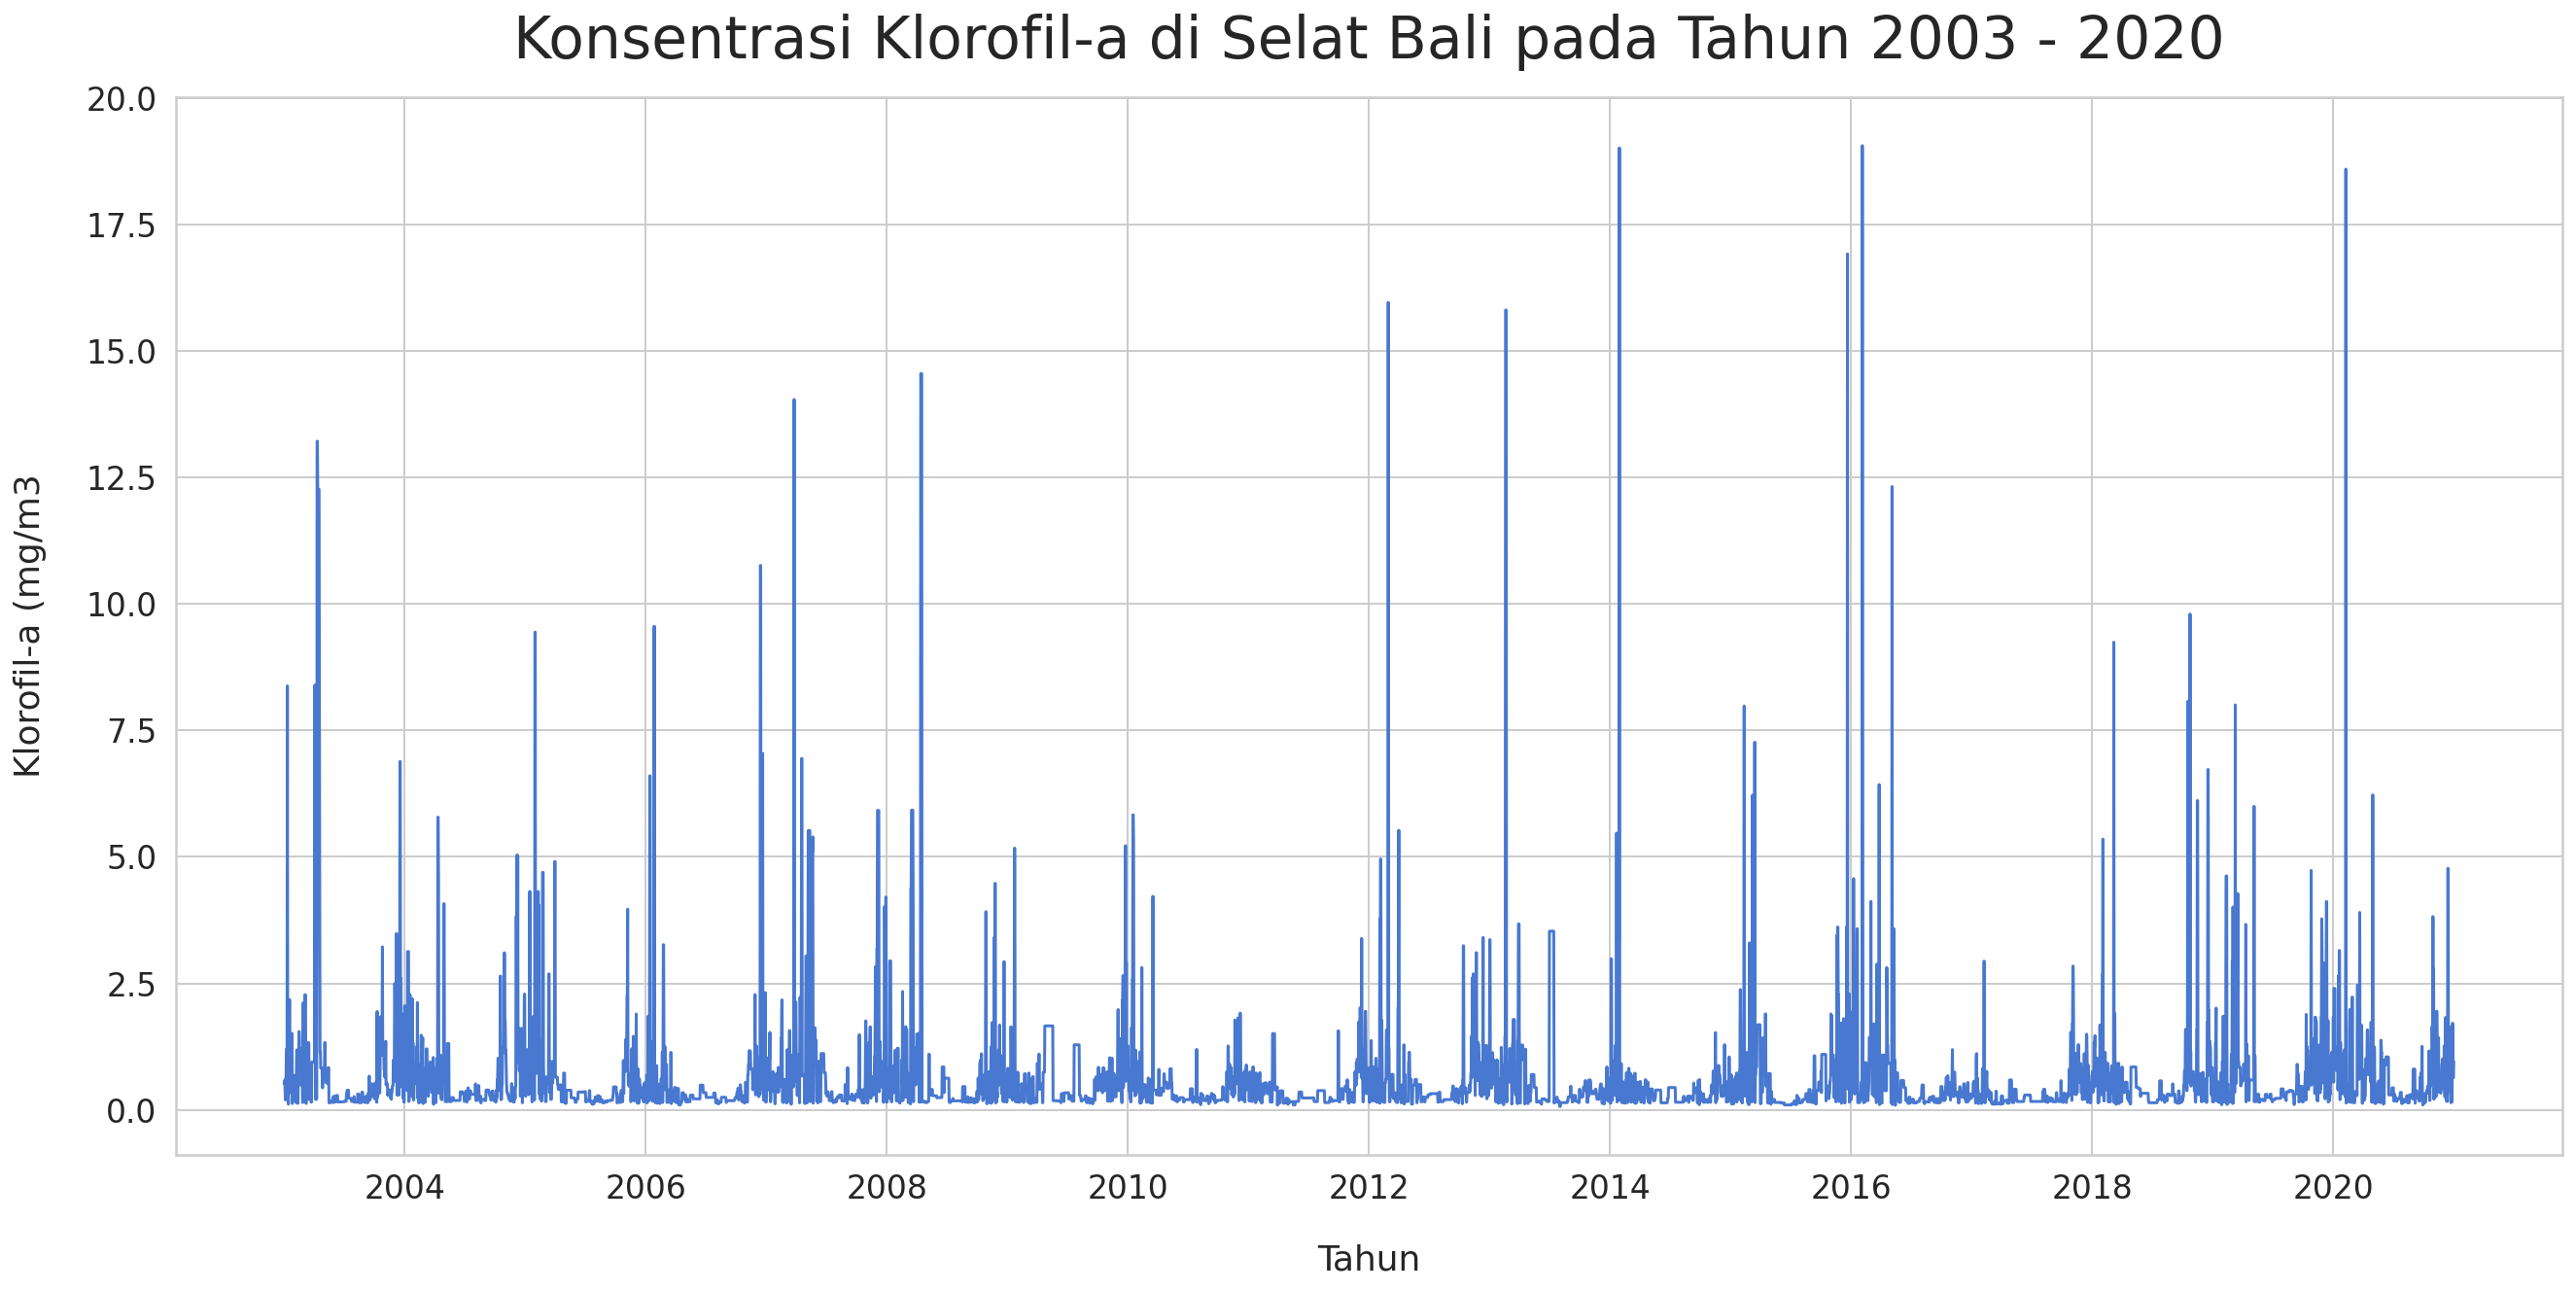

In [ ]:
sns.lineplot(x=df.index, y="Chl_a", data=df)
plt.ylabel('Klorofil-a (mg/m3')
plt.xlabel('Tahun')
plt.title('Konsentrasi Klorofil-a di Selat Bali pada Tahun 2003 - 2020',fontsize=30)

# Preprocessing

Splitting The Data into Training (Training + Validation) and Test

In [ ]:
train_size = int(len(df) * 0.9)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

5917 658


In [ ]:
dates = pd.to_datetime(df_date['Date'])
dates_train = dates.iloc[:train_size]
dates_test = dates.iloc[train_size:]

Normalizing The Data

In [ ]:
from sklearn.preprocessing import RobustScaler

f_columns = ['SST']

f_transformer = RobustScaler()
cnt_transformer = RobustScaler()

f_transformer = f_transformer.fit(train[f_columns].to_numpy())
cnt_transformer = cnt_transformer.fit(train[['Chl_a']])

train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
train['Chl_a'] = cnt_transformer.transform(train[['Chl_a']])

test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())
test['Chl_a'] = cnt_transformer.transform(test[['Chl_a']])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

In [ ]:
train.Chl_a

Date
2003-01-01     0.429638
2003-01-02     0.429638
2003-01-03     0.587268
2003-01-04     0.193910
2003-01-05    -0.284256
                ...    
2019-03-10    17.004098
2019-03-11     0.473126
2019-03-12     0.441541
2019-03-13     0.441541
2019-03-14     3.735180
Name: Chl_a, Length: 5917, dtype: float64

In [ ]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [ ]:
time_steps = 14

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train.Chl_a, time_steps)
X_test, y_test = create_dataset(test, test.Chl_a, time_steps)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(5903, 14, 5) (5903,)
(644, 14, 5) (644,)


In [ ]:
def root_mean_squared_error(y_true, y_pred):
  return K.sqrt(K.mean(K.square(y_pred - y_true))) 

# LSTM Model Training

## Model 1 (80, 10, 10 Split - 128 Neurons)

In [ ]:
model = keras.Sequential()
model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=128,
      input_shape=(X_train.shape[1], X_train.shape[2])
    )
  )
)
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))
model.compile(optimizer='adam', loss=root_mean_squared_error, metrics=['mae'])

In [ ]:
history = model.fit(
    X_train, y_train, 
    epochs=30, 
    batch_size=32, 
    validation_split=0.1,
    shuffle=False
)

Epoch 1/30
166/166 [==============================] - 7s 29ms/step - loss: 1.6542 - mae: 1.0222 - val_loss: 1.5650 - val_mae: 0.8605
Epoch 2/30
166/166 [==============================] - 4s 24ms/step - loss: 1.4730 - mae: 0.8841 - val_loss: 1.5028 - val_mae: 0.8052
Epoch 3/30
166/166 [==============================] - 4s 23ms/step - loss: 1.3970 - mae: 0.8085 - val_loss: 1.5084 - val_mae: 0.8386
Epoch 4/30
166/166 [==============================] - 4s 24ms/step - loss: 1.3627 - mae: 0.7679 - val_loss: 1.5350 - val_mae: 0.8700
Epoch 5/30
166/166 [==============================] - 4s 23ms/step - loss: 1.3648 - mae: 0.7792 - val_loss: 1.5297 - val_mae: 0.8547
Epoch 6/30
166/166 [==============================] - 4s 23ms/step - loss: 1.3466 - mae: 0.7609 - val_loss: 1.5356 - val_mae: 0.8599
Epoch 7/30
166/166 [==============================] - 4s 23ms/step - loss: 1.3316 - mae: 0.7490 - val_loss: 1.4553 - val_mae: 0.7690
Epoch 8/30
166/166 [==============================] - 4s 24ms/step - 

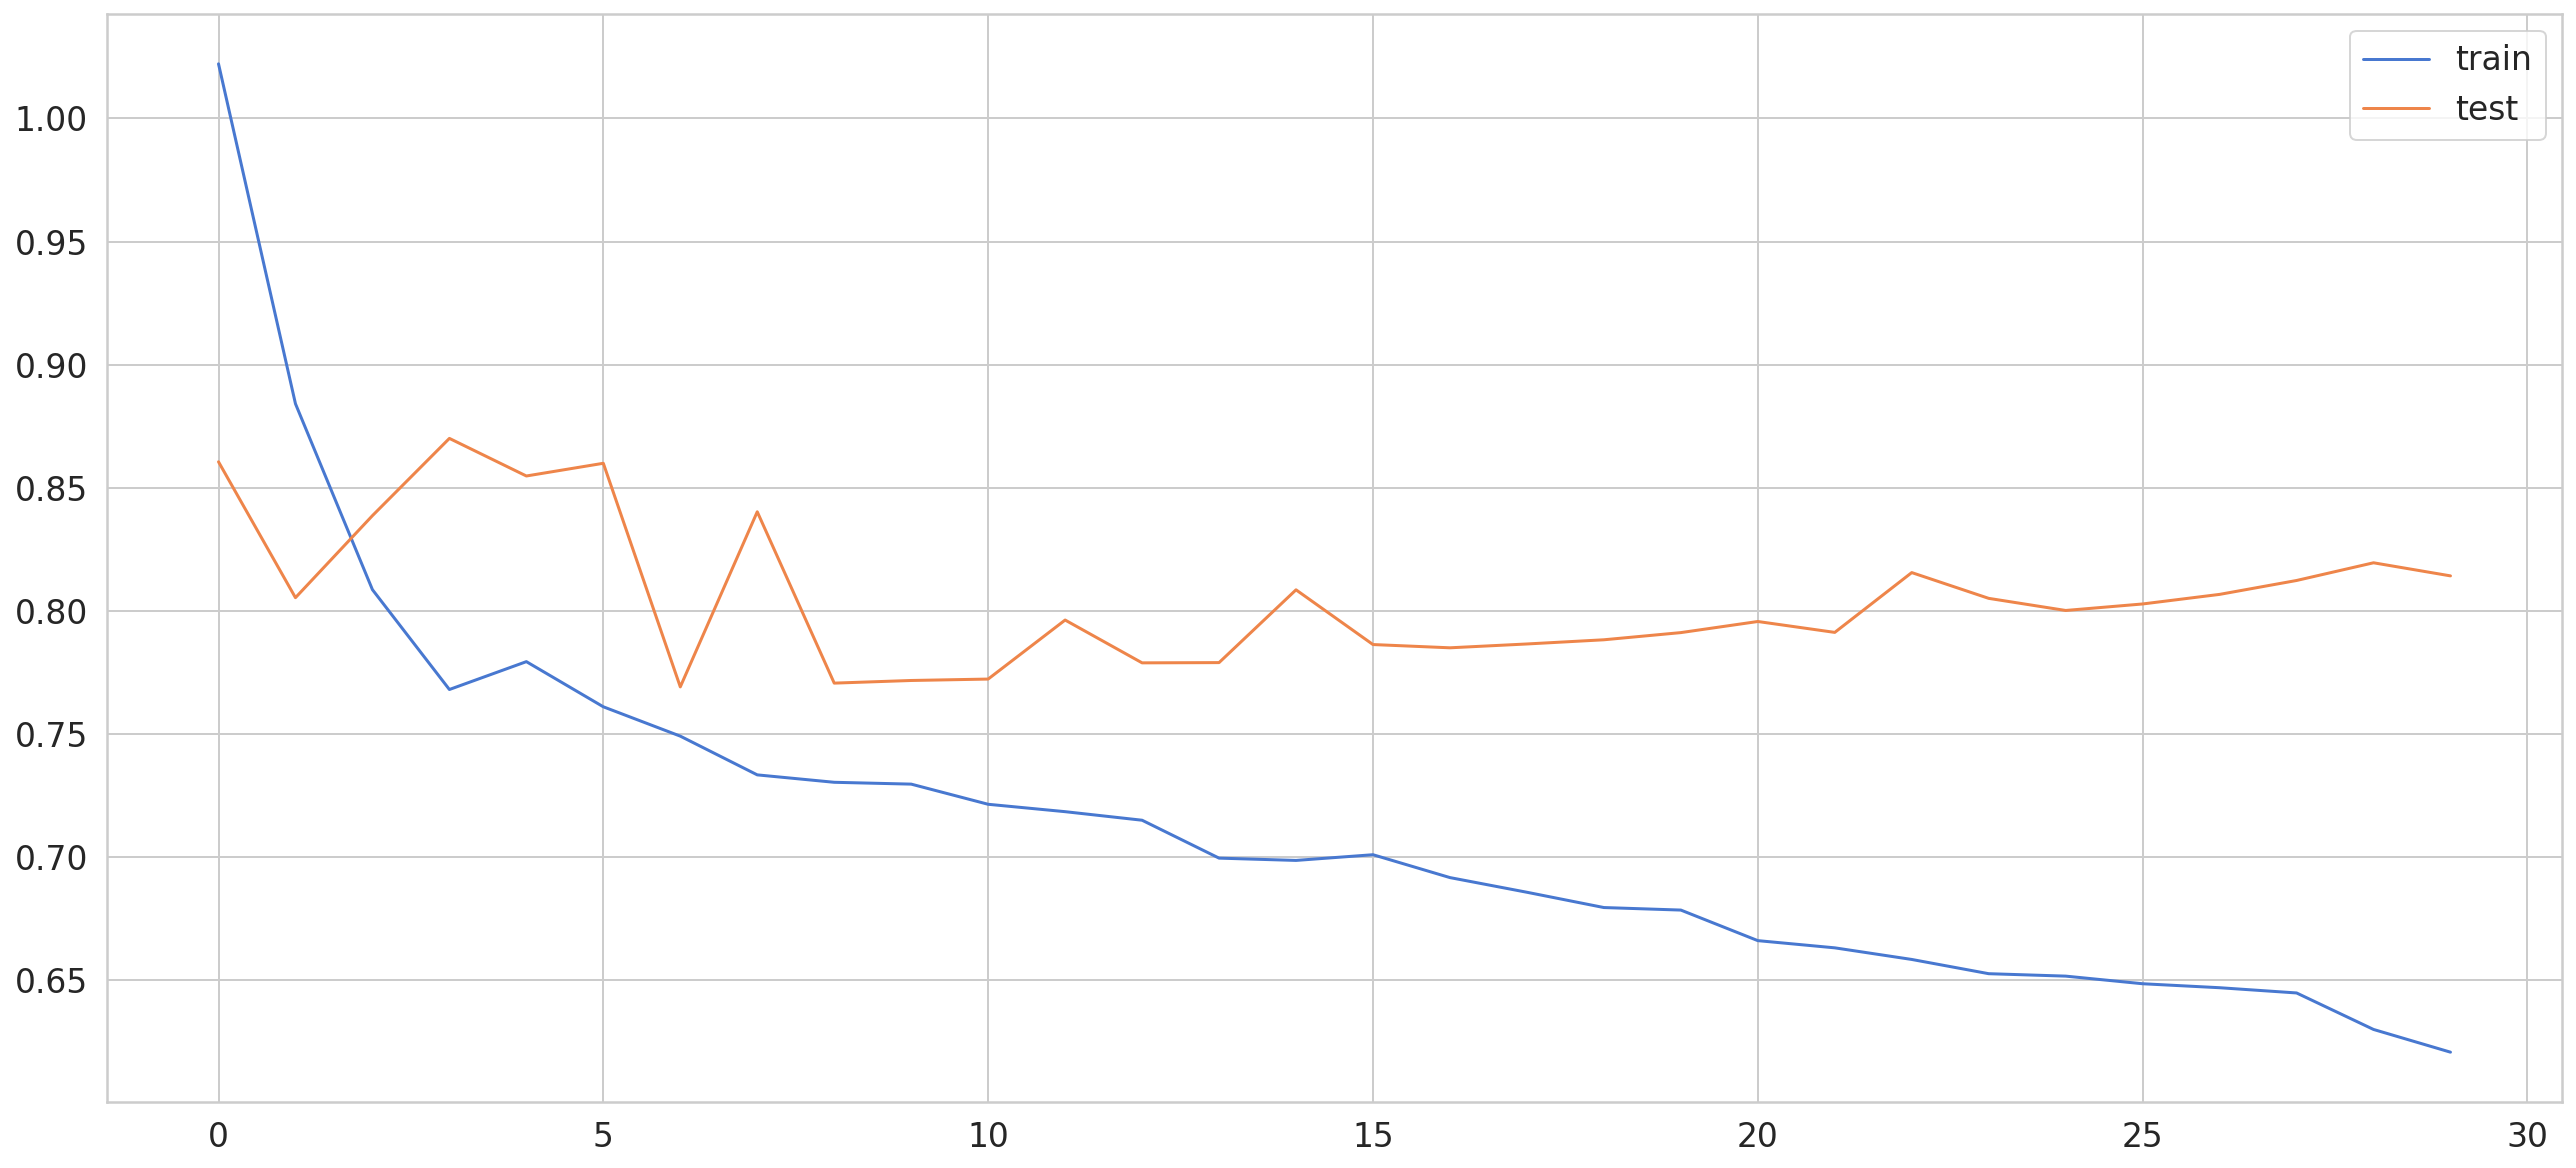

In [ ]:
plt.plot(history.history['mae'], label='train')
plt.plot(history.history['val_mae'], label='test')
plt.legend();

## Model 2 (80, 10, 10 Split - 256 Neurons)

In [ ]:
model2 = keras.Sequential()
model2.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=256,
      input_shape=(X_train.shape[1], X_train.shape[2])
    )
  )
)
model2.add(keras.layers.Dropout(rate=0.2))
model2.add(keras.layers.Dense(units=1))
model2.compile(optimizer='adam', loss=root_mean_squared_error, metrics=['mae'])

In [ ]:
history2 = model2.fit(
    X_train, y_train, 
    epochs=30, 
    batch_size=32, 
    validation_split=0.1,
    shuffle=False
)

Epoch 1/30
166/166 [==============================] - 18s 91ms/step - loss: 1.6963 - mae: 1.0678 - val_loss: 1.5480 - val_mae: 0.8458
Epoch 2/30
166/166 [==============================] - 14s 85ms/step - loss: 1.4345 - mae: 0.8482 - val_loss: 1.4867 - val_mae: 0.7995
Epoch 3/30
166/166 [==============================] - 14s 84ms/step - loss: 1.3733 - mae: 0.7893 - val_loss: 1.5034 - val_mae: 0.8342
Epoch 4/30
166/166 [==============================] - 17s 103ms/step - loss: 1.3652 - mae: 0.7779 - val_loss: 1.4464 - val_mae: 0.7702
Epoch 5/30
166/166 [==============================] - 15s 90ms/step - loss: 1.3512 - mae: 0.7736 - val_loss: 1.4605 - val_mae: 0.7714
Epoch 6/30
166/166 [==============================] - 15s 90ms/step - loss: 1.3279 - mae: 0.7526 - val_loss: 1.4682 - val_mae: 0.7743
Epoch 7/30
166/166 [==============================] - 14s 87ms/step - loss: 1.3094 - mae: 0.7293 - val_loss: 1.4928 - val_mae: 0.8015
Epoch 8/30
166/166 [==============================] - 15s 88m

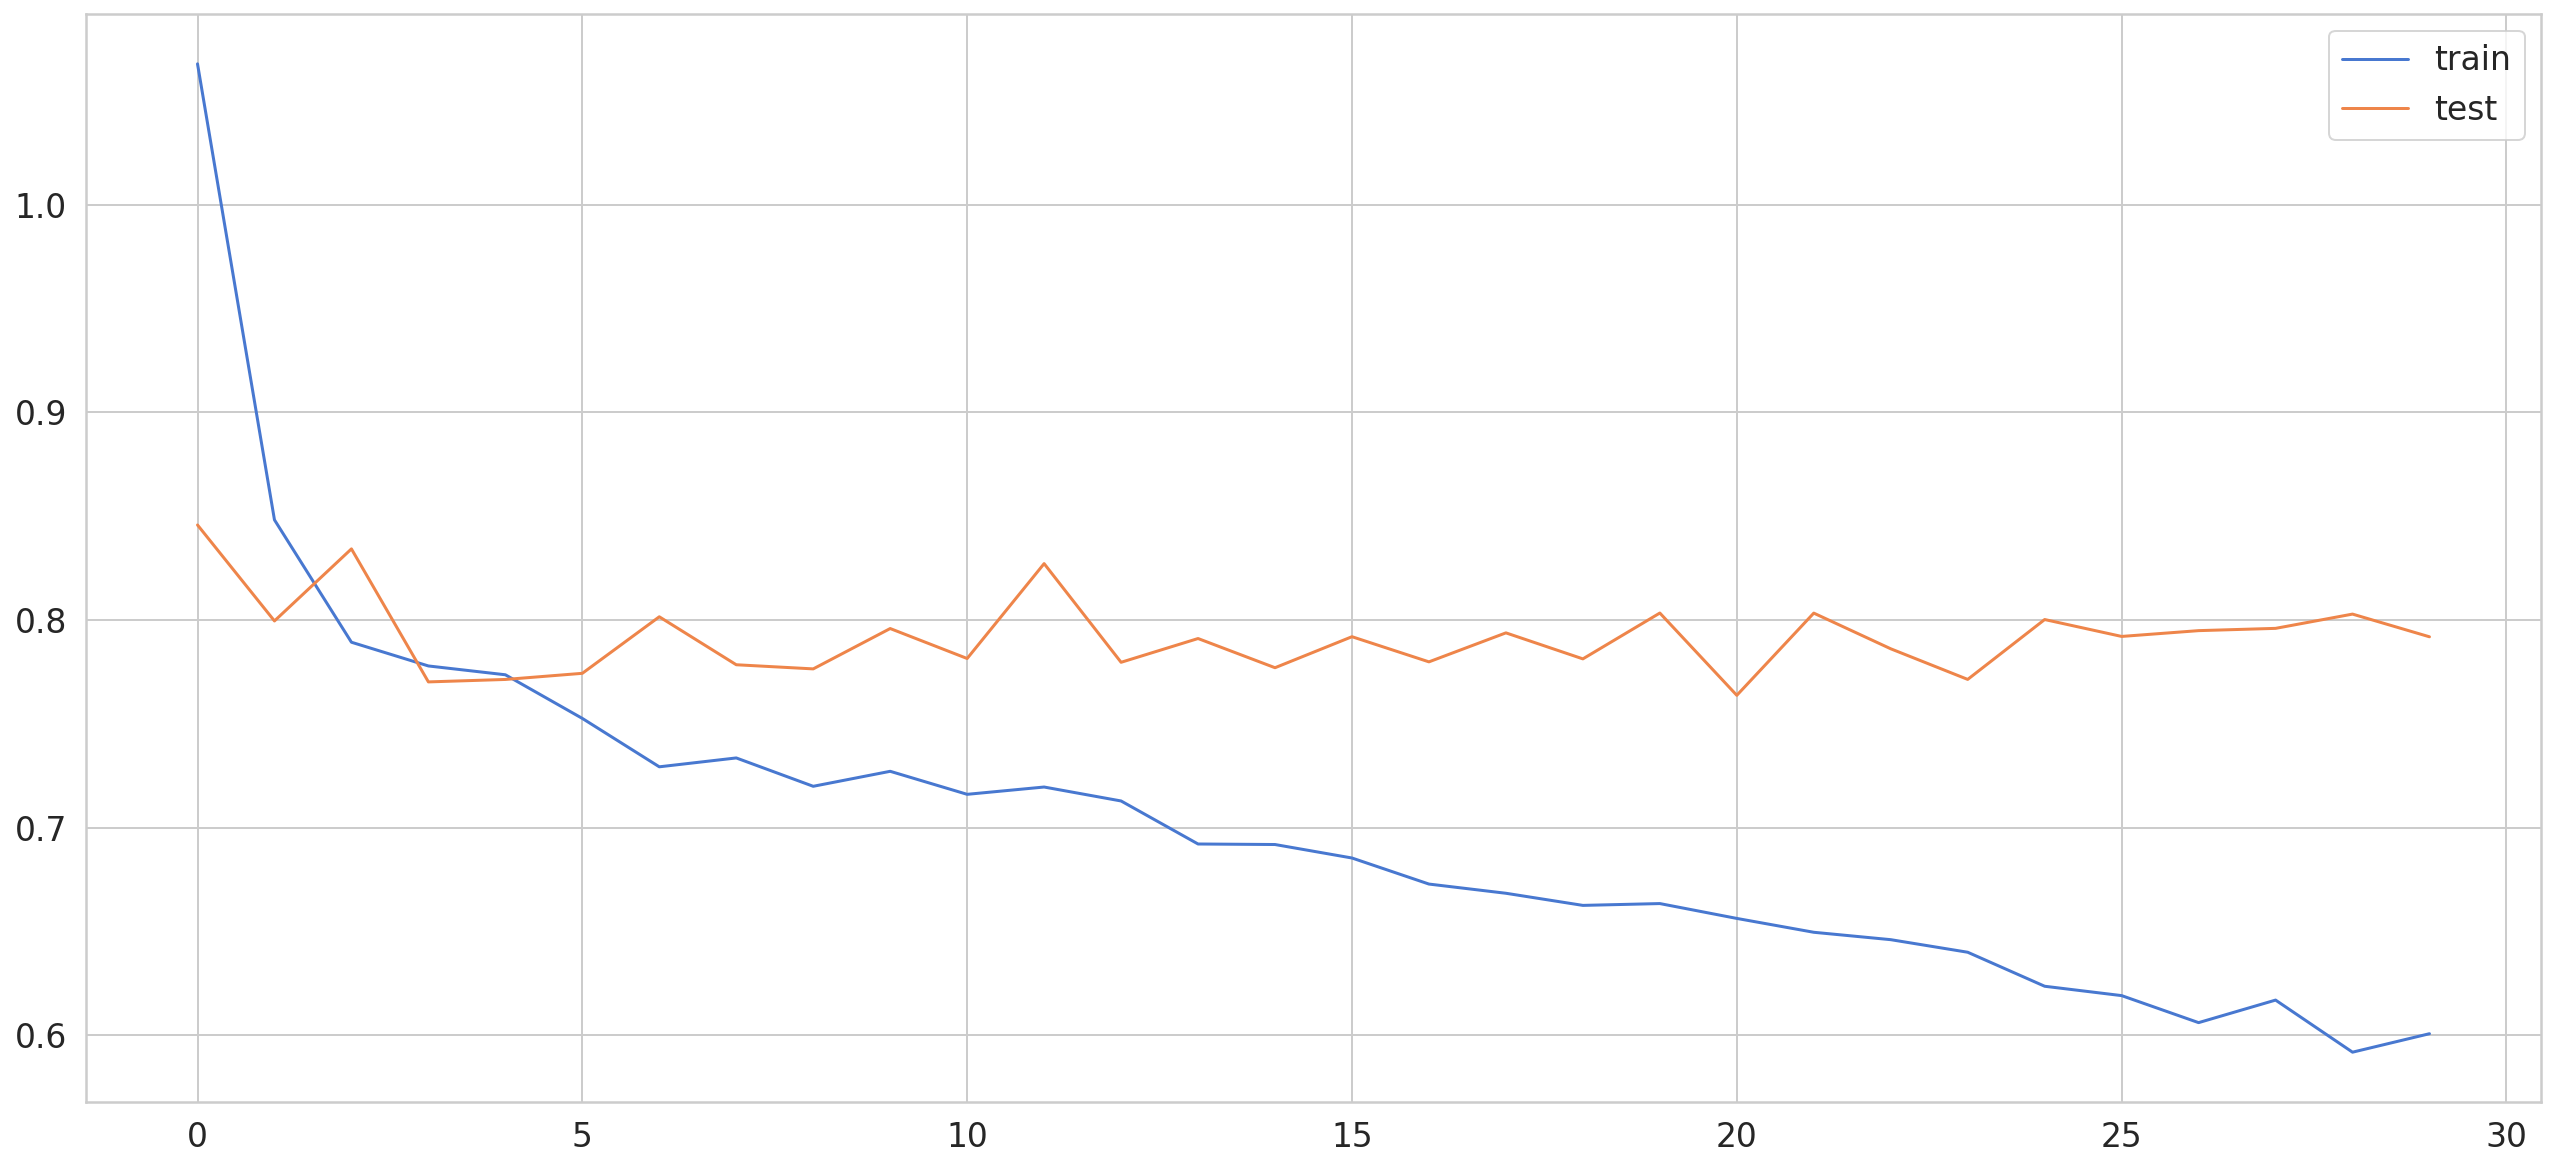

In [ ]:
plt.plot(history2.history['mae'], label='train')
plt.plot(history2.history['val_mae'], label='test')
plt.legend();

## Model 3 (75, 15, 10 Split - 128 Neuron)

In [ ]:
model3 = keras.Sequential()
model3.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=128,
      input_shape=(X_train.shape[1], X_train.shape[2])
    )
  )
)
model3.add(keras.layers.Dropout(rate=0.2))
model3.add(keras.layers.Dense(units=1))
model3.compile(optimizer='adam', loss=root_mean_squared_error, metrics=['mae'])

In [ ]:
history3 = model3.fit(
    X_train, y_train, 
    epochs=30, 
    batch_size=32, 
    validation_split=0.15,
    shuffle=False
)

Epoch 1/30
157/157 [==============================] - 11s 41ms/step - loss: 1.7242 - mae: 1.0612 - val_loss: 1.1253 - val_mae: 0.6690
Epoch 2/30
157/157 [==============================] - 6s 35ms/step - loss: 1.4996 - mae: 0.8892 - val_loss: 1.1956 - val_mae: 0.7901
Epoch 3/30
157/157 [==============================] - 6s 35ms/step - loss: 1.4571 - mae: 0.8358 - val_loss: 1.0526 - val_mae: 0.5965
Epoch 4/30
157/157 [==============================] - 5s 35ms/step - loss: 1.4152 - mae: 0.7962 - val_loss: 1.0732 - val_mae: 0.6292
Epoch 5/30
157/157 [==============================] - 6s 36ms/step - loss: 1.4479 - mae: 0.8415 - val_loss: 1.1143 - val_mae: 0.6849
Epoch 6/30
157/157 [==============================] - 6s 36ms/step - loss: 1.3922 - mae: 0.7789 - val_loss: 1.0555 - val_mae: 0.5961
Epoch 7/30
157/157 [==============================] - 6s 36ms/step - loss: 1.3892 - mae: 0.7801 - val_loss: 1.0552 - val_mae: 0.5949
Epoch 8/30
157/157 [==============================] - 5s 35ms/step -

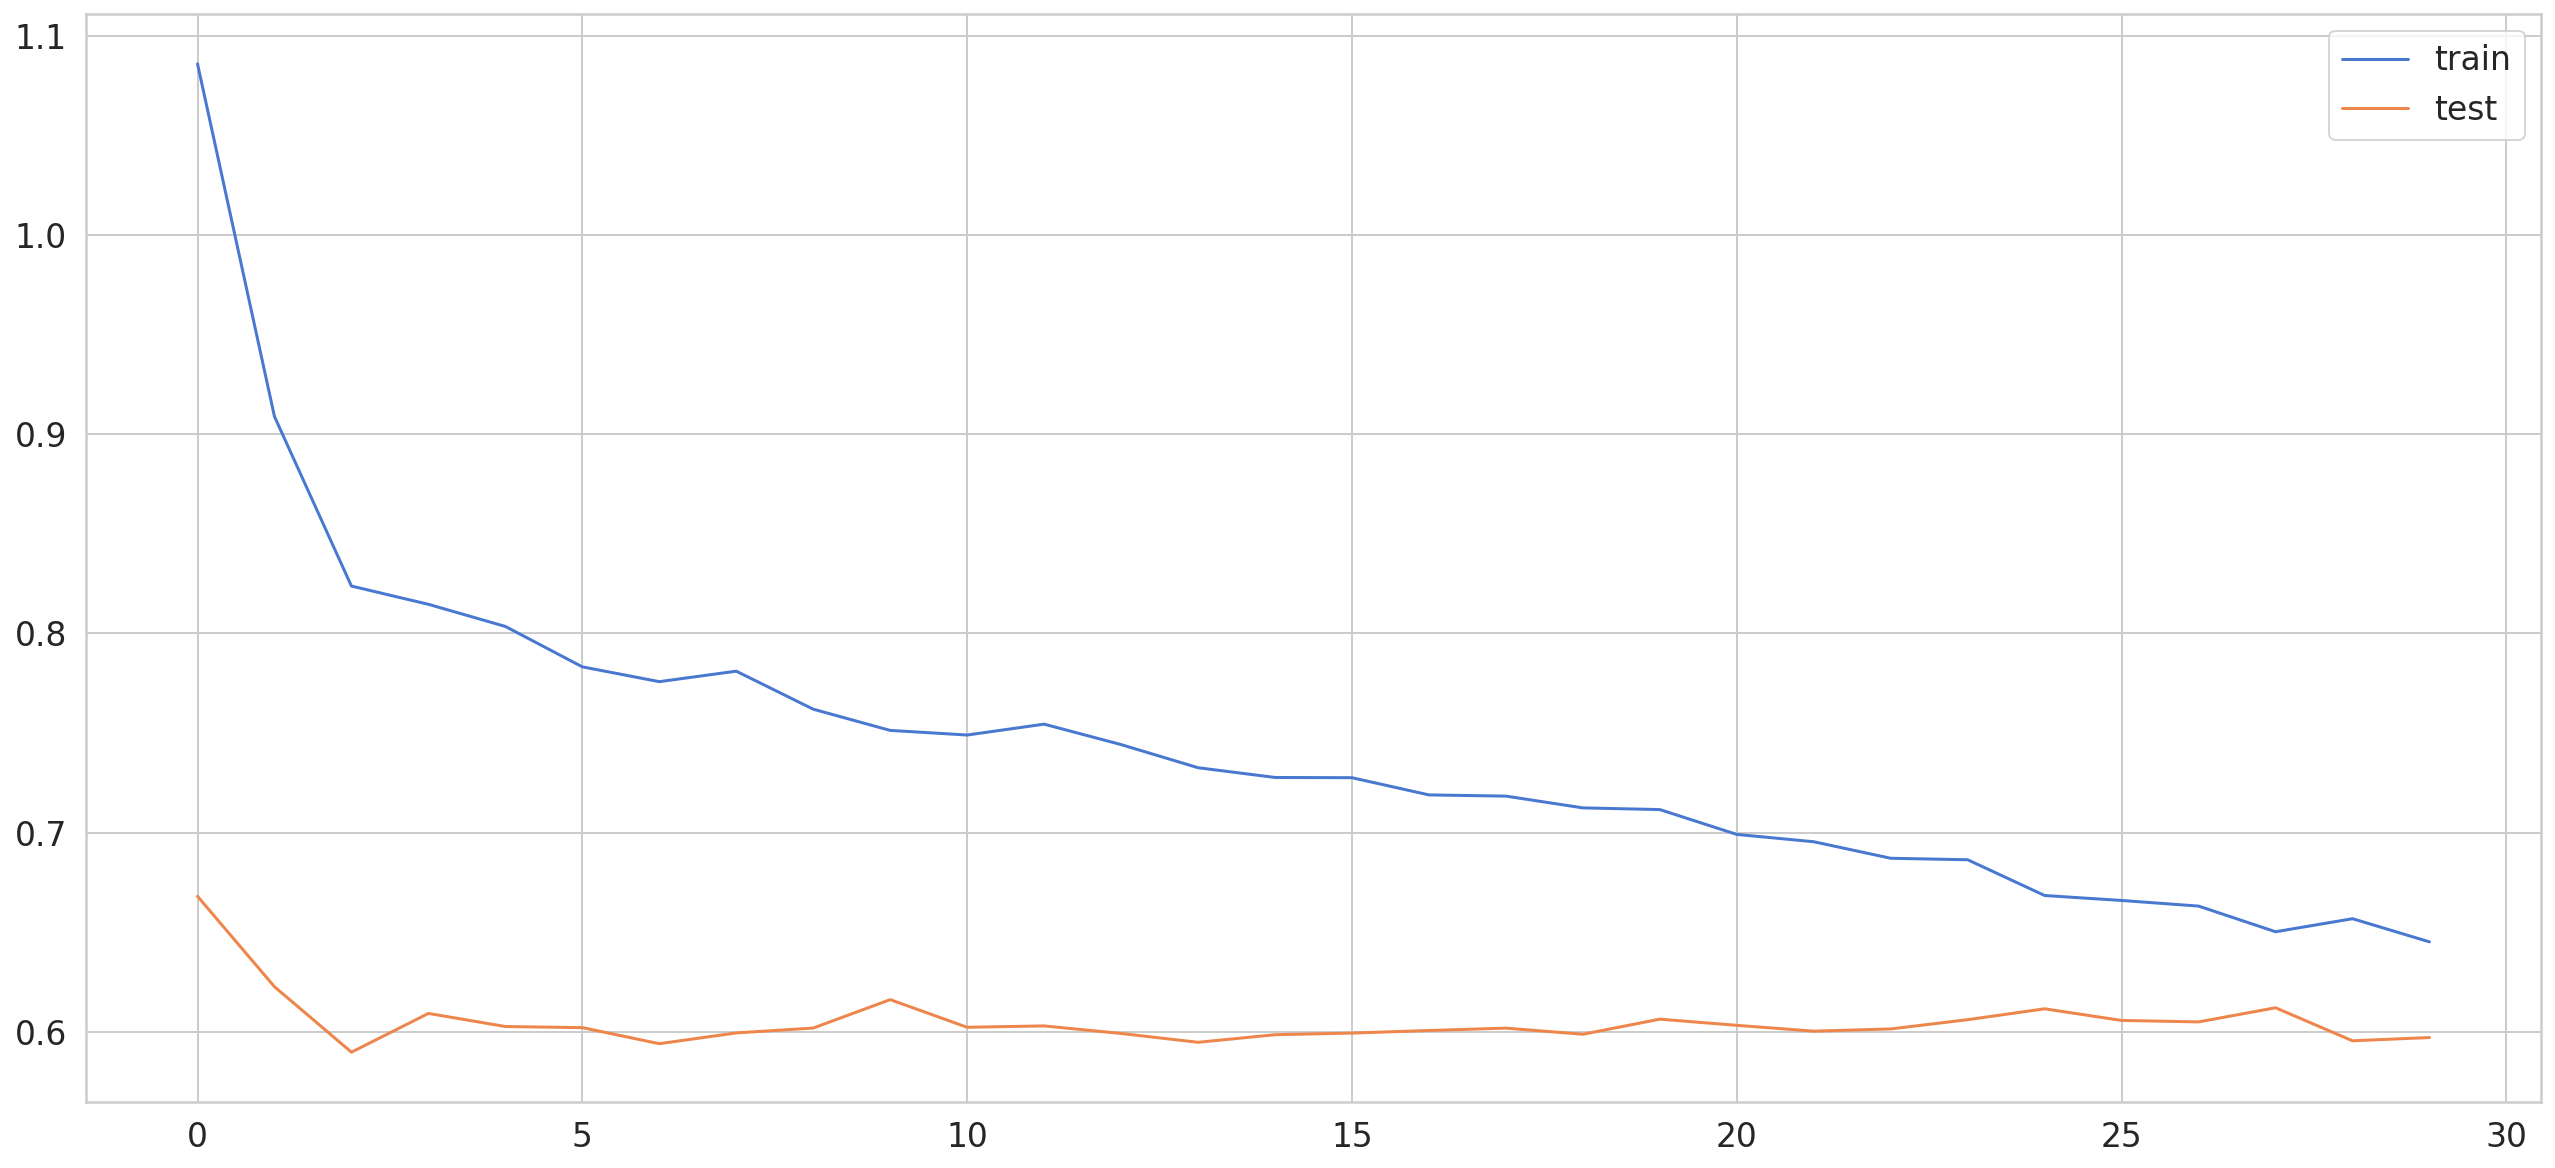

In [ ]:
plt.plot(history3.history['mae'], label='train')
plt.plot(history3.history['val_mae'], label='test')
plt.legend();

## Model 4 (75, 15, 10 Split - 256 Neurons)

In [ ]:
model4 = keras.Sequential()
model4.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=256,
      input_shape=(X_train.shape[1], X_train.shape[2])
    )
  )
)
model4.add(keras.layers.Dropout(rate=0.2))
model4.add(keras.layers.Dense(units=1))
model4.compile(optimizer='adam', loss=root_mean_squared_error, metrics=['mae'])

In [ ]:
history4 = model4.fit(
    X_train, y_train, 
    epochs=30, 
    batch_size=32, 
    validation_split=0.15,
    shuffle=False
)

Epoch 1/30
157/157 [==============================] - 21s 115ms/step - loss: 1.7808 - mae: 1.1297 - val_loss: 1.1499 - val_mae: 0.6665
Epoch 2/30
157/157 [==============================] - 15s 94ms/step - loss: 1.4926 - mae: 0.8782 - val_loss: 1.0694 - val_mae: 0.6010
Epoch 3/30
157/157 [==============================] - 17s 111ms/step - loss: 1.4178 - mae: 0.8079 - val_loss: 1.0588 - val_mae: 0.5901
Epoch 4/30
157/157 [==============================] - 17s 110ms/step - loss: 1.4624 - mae: 0.8683 - val_loss: 1.0637 - val_mae: 0.6005
Epoch 5/30
157/157 [==============================] - 17s 110ms/step - loss: 1.4163 - mae: 0.8161 - val_loss: 1.0644 - val_mae: 0.5995
Epoch 6/30
157/157 [==============================] - 18s 112ms/step - loss: 1.3939 - mae: 0.7918 - val_loss: 1.0680 - val_mae: 0.6032
Epoch 7/30
157/157 [==============================] - 16s 104ms/step - loss: 1.3611 - mae: 0.7549 - val_loss: 1.0942 - val_mae: 0.6367
Epoch 8/30
157/157 [==============================] - 16

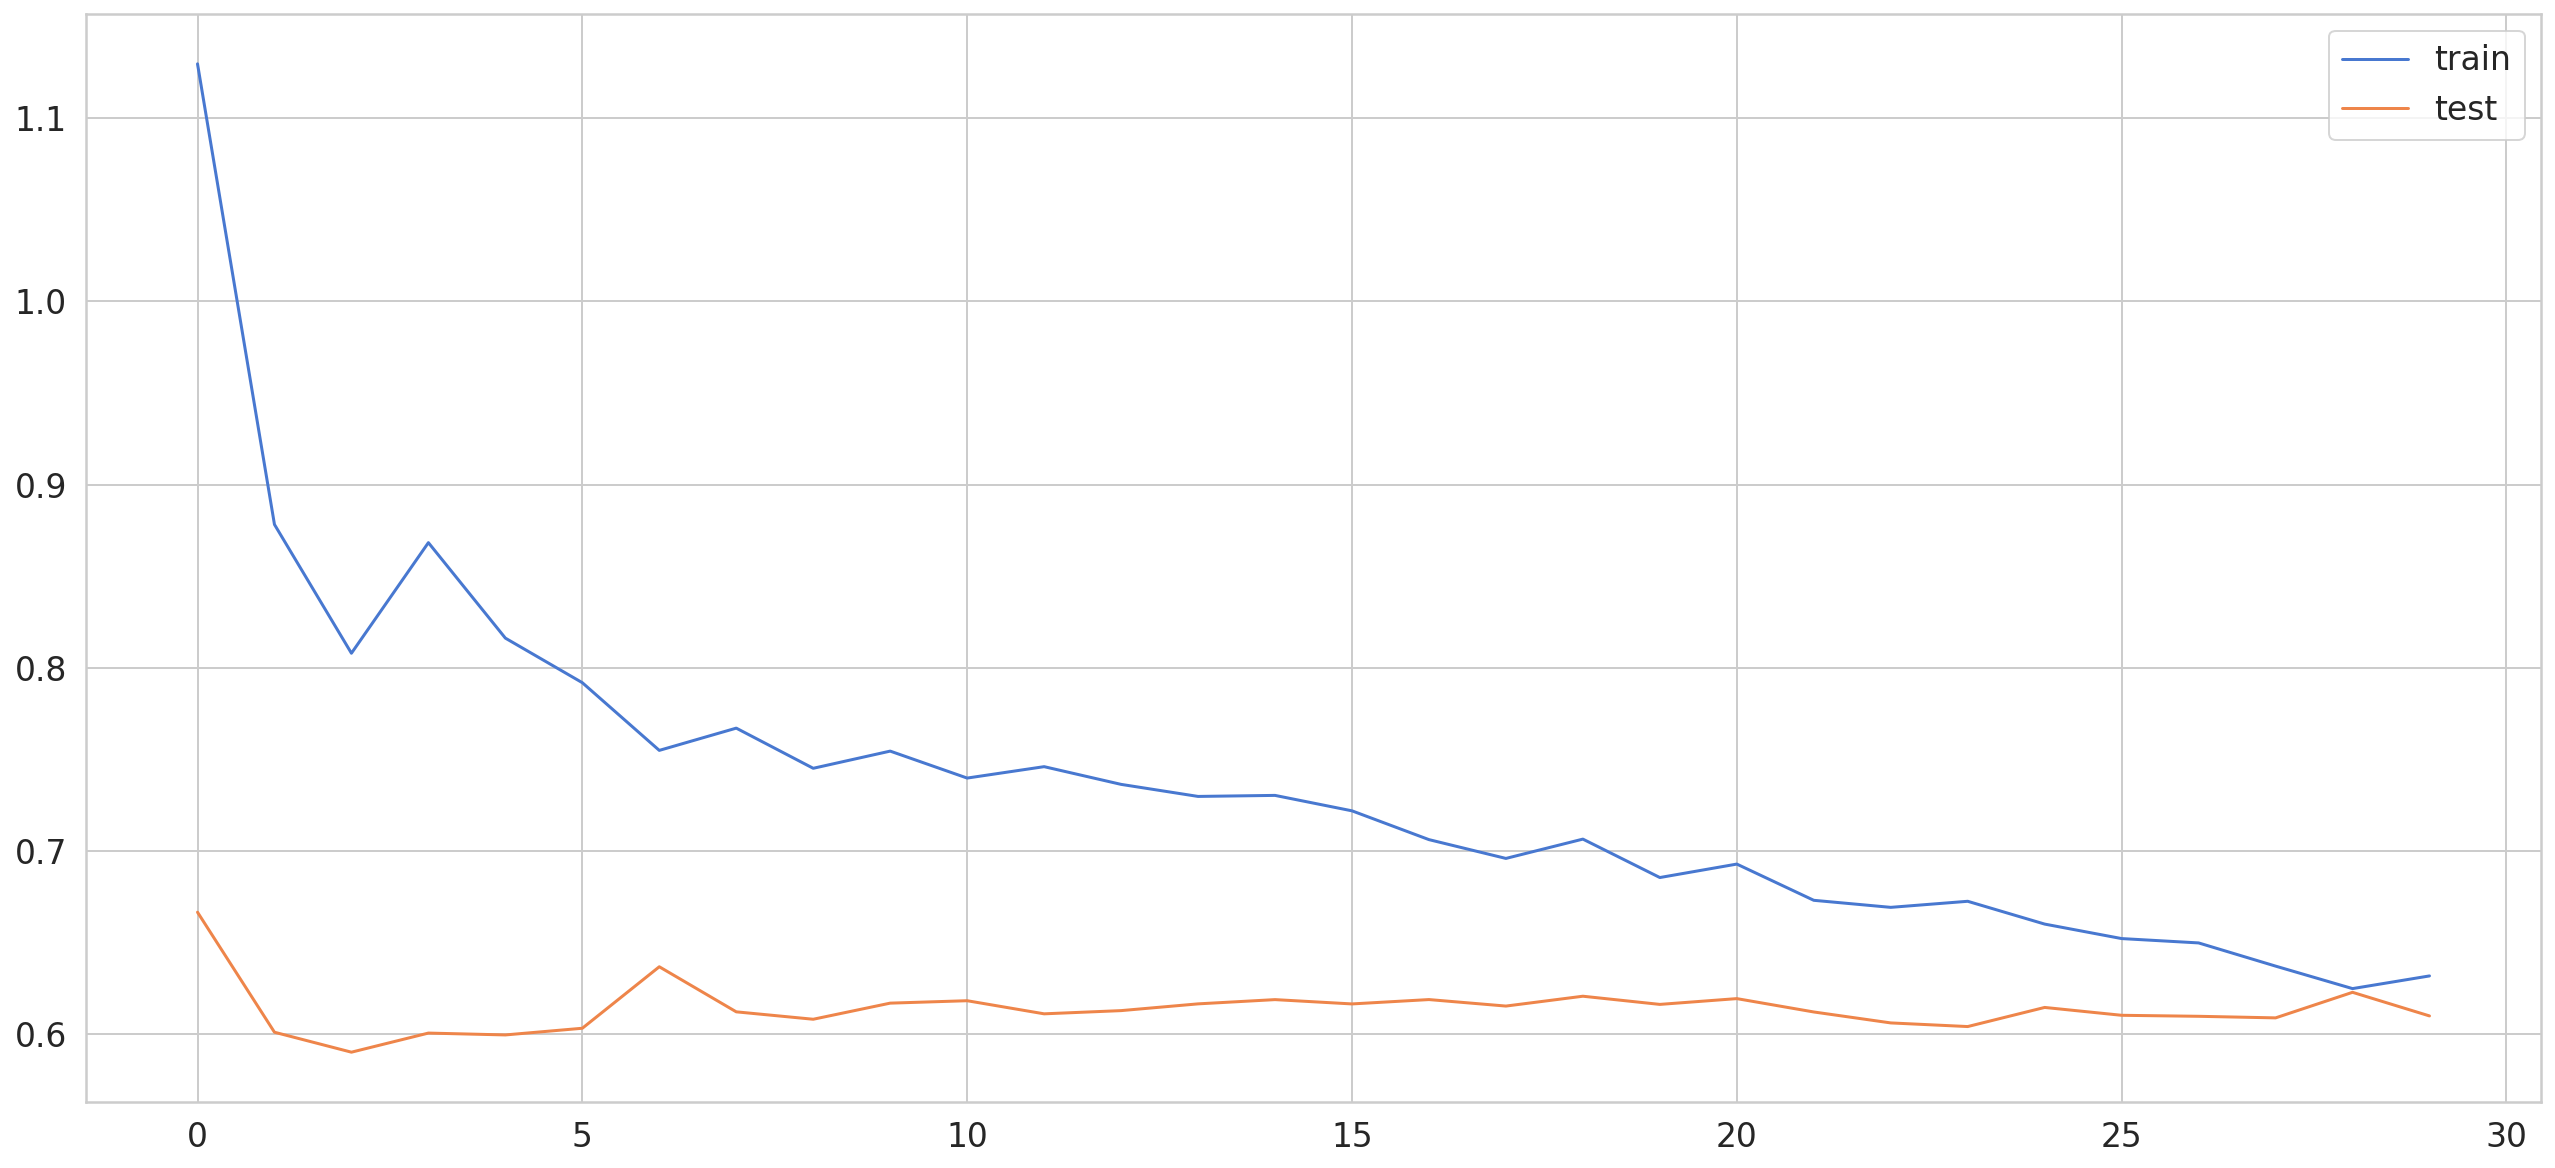

In [ ]:
plt.plot(history4.history['mae'], label='train')
plt.plot(history4.history['val_mae'], label='test')
plt.legend();

## Model 5 (70, 20, 10 Split - 128 Neurons)

In [ ]:
model5 = keras.Sequential()
model5.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=128,
      input_shape=(X_train.shape[1], X_train.shape[2])
    )
  )
)
model5.add(keras.layers.Dropout(rate=0.2))
model5.add(keras.layers.Dense(units=1))
model5.compile(optimizer='adam', loss=root_mean_squared_error, metrics=['mae'])

In [ ]:
history5 = model5.fit(
    X_train, y_train, 
    epochs=30, 
    batch_size=32, 
    validation_split=0.2,
    shuffle=False
)

Epoch 1/30
148/148 [==============================] - 9s 35ms/step - loss: 1.6395 - mae: 1.0375 - val_loss: 1.5600 - val_mae: 0.7968
Epoch 2/30
148/148 [==============================] - 5s 31ms/step - loss: 1.4493 - mae: 0.9039 - val_loss: 1.5108 - val_mae: 0.7539
Epoch 3/30
148/148 [==============================] - 4s 29ms/step - loss: 1.4045 - mae: 0.8569 - val_loss: 1.4982 - val_mae: 0.7487
Epoch 4/30
148/148 [==============================] - 4s 29ms/step - loss: 1.3518 - mae: 0.8116 - val_loss: 1.5038 - val_mae: 0.7481
Epoch 5/30
148/148 [==============================] - 4s 30ms/step - loss: 1.3271 - mae: 0.7785 - val_loss: 1.4971 - val_mae: 0.7249
Epoch 6/30
148/148 [==============================] - 4s 29ms/step - loss: 1.3086 - mae: 0.7637 - val_loss: 1.4981 - val_mae: 0.7239
Epoch 7/30
148/148 [==============================] - 4s 30ms/step - loss: 1.3083 - mae: 0.7702 - val_loss: 1.5045 - val_mae: 0.7278
Epoch 8/30
148/148 [==============================] - 4s 29ms/step - 

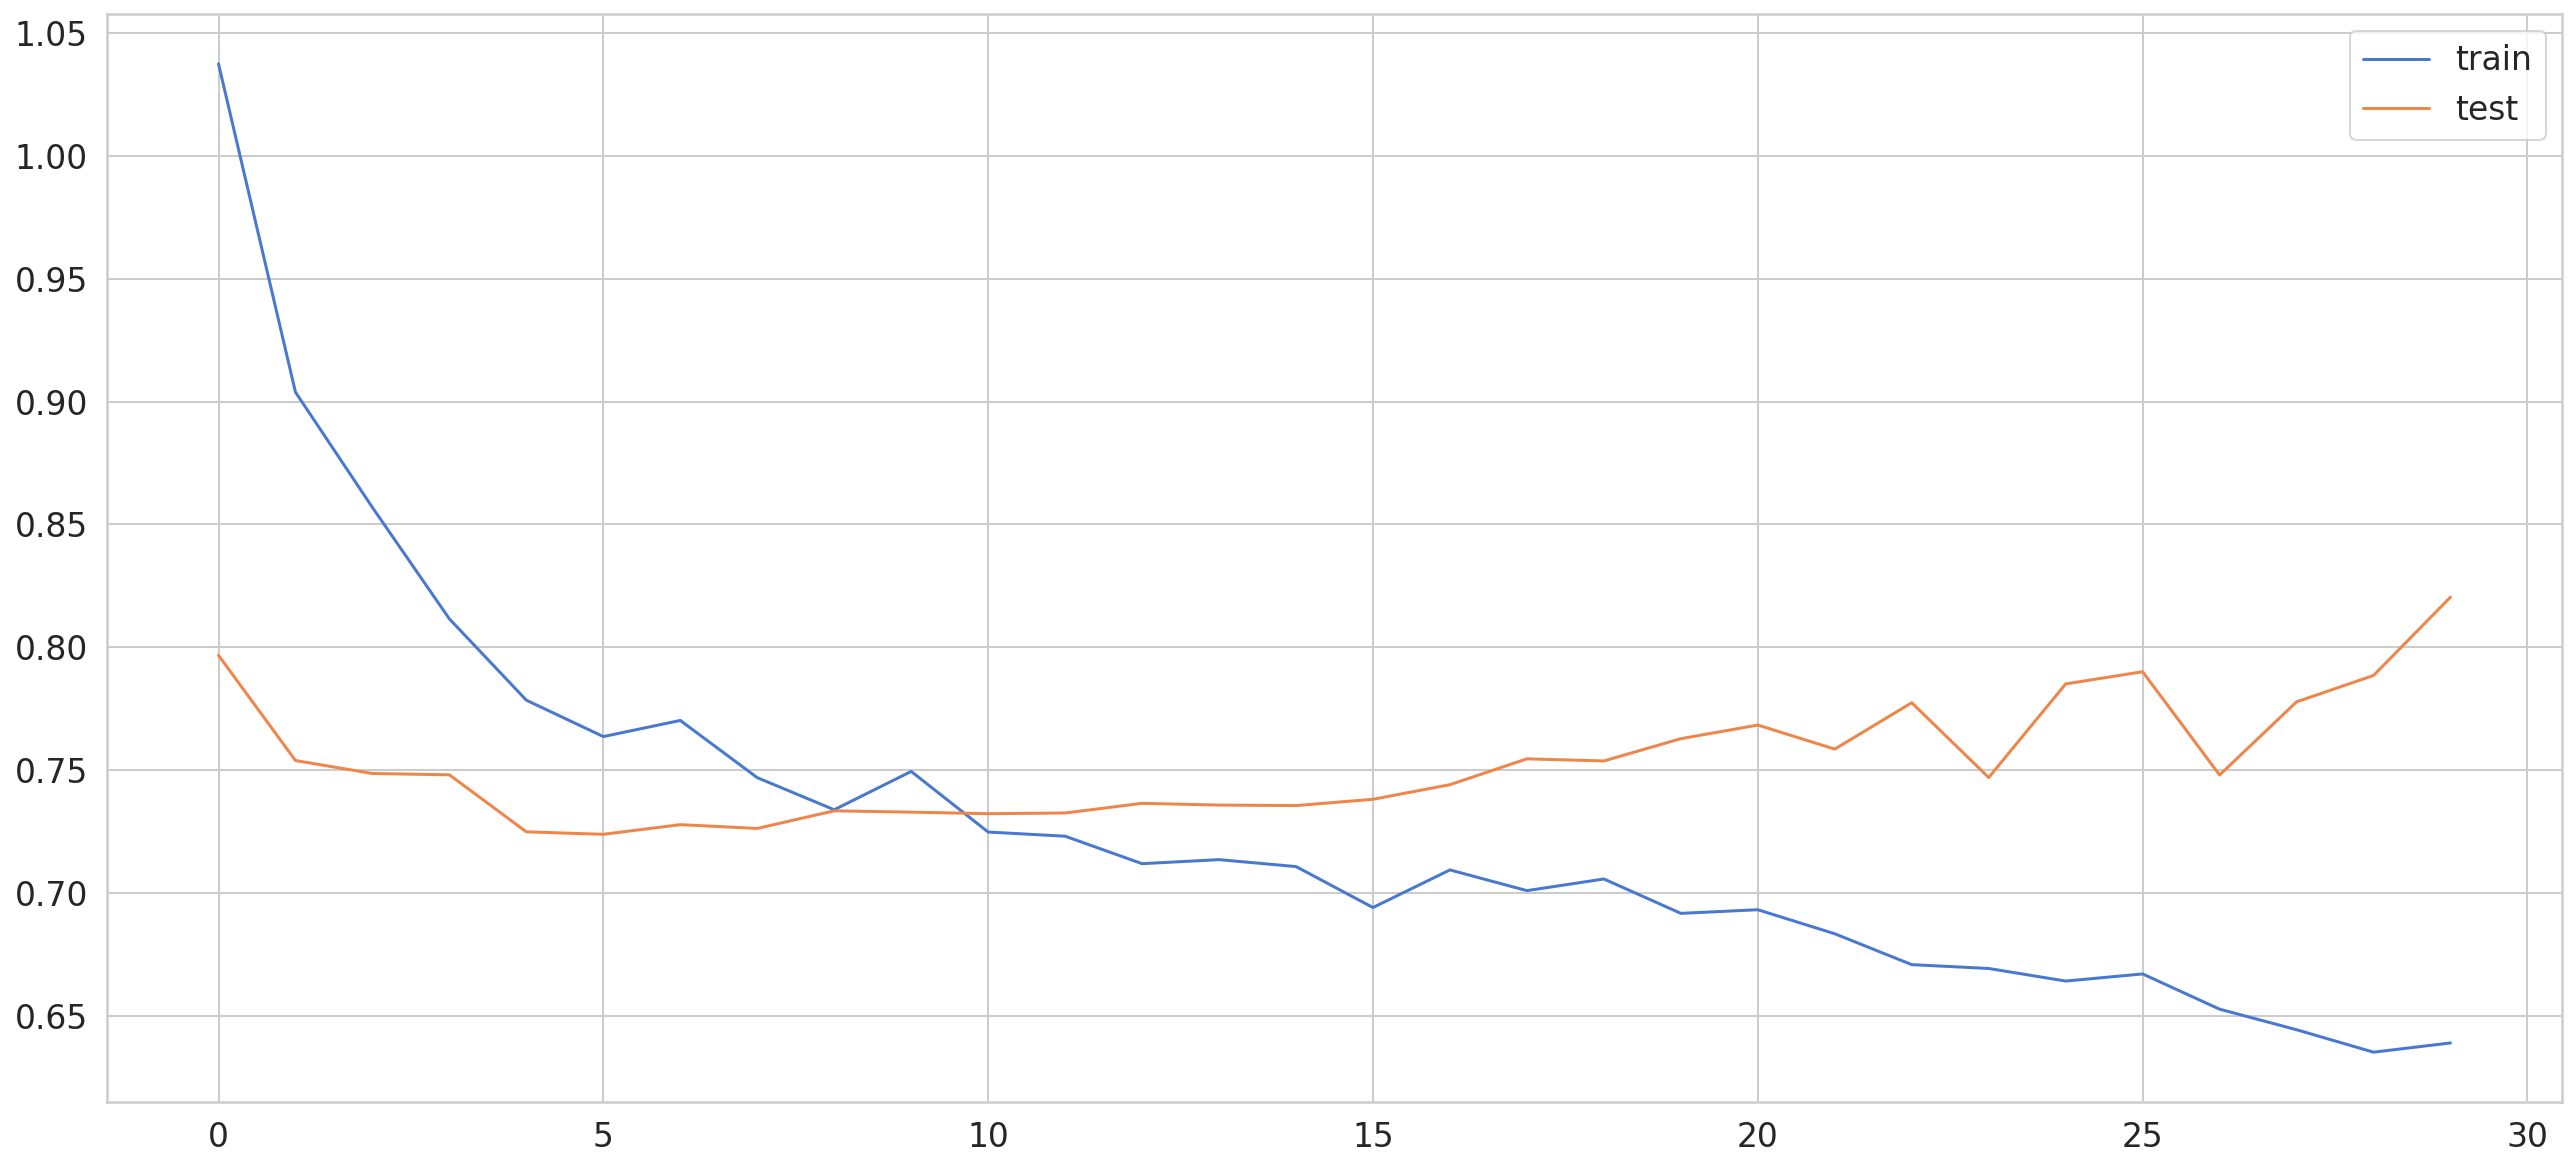

In [ ]:
plt.plot(history5.history['mae'], label='train')
plt.plot(history5.history['val_mae'], label='test')
plt.legend();

## Model 6 (70, 20, 10 Split - 256 Neurons)

In [ ]:
model6 = keras.Sequential()
model6.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=256,
      input_shape=(X_train.shape[1], X_train.shape[2])
    )
  )
)
model6.add(keras.layers.Dropout(rate=0.2))
model6.add(keras.layers.Dense(units=1))
model6.compile(optimizer='adam', loss=root_mean_squared_error, metrics=['mae'])

In [ ]:
history6 = model6.fit(
    X_train, y_train, 
    epochs=30, 
    batch_size=32, 
    validation_split=0.2,
    shuffle=False
)

Epoch 1/30
148/148 [==============================] - 19s 105ms/step - loss: 1.7065 - mae: 1.1096 - val_loss: 1.5768 - val_mae: 0.8005
Epoch 2/30
148/148 [==============================] - 15s 101ms/step - loss: 1.4308 - mae: 0.8787 - val_loss: 1.5000 - val_mae: 0.7493
Epoch 3/30
148/148 [==============================] - 15s 102ms/step - loss: 1.3617 - mae: 0.8222 - val_loss: 1.5250 - val_mae: 0.7589
Epoch 4/30
148/148 [==============================] - 15s 102ms/step - loss: 1.3161 - mae: 0.7713 - val_loss: 1.5189 - val_mae: 0.7632
Epoch 5/30
148/148 [==============================] - 15s 101ms/step - loss: 1.3322 - mae: 0.8081 - val_loss: 1.5203 - val_mae: 0.7347
Epoch 6/30
148/148 [==============================] - 15s 103ms/step - loss: 1.2931 - mae: 0.7596 - val_loss: 1.5413 - val_mae: 0.7509
Epoch 7/30
148/148 [==============================] - 15s 103ms/step - loss: 1.2688 - mae: 0.7311 - val_loss: 1.5216 - val_mae: 0.7276
Epoch 8/30
148/148 [==============================] - 1

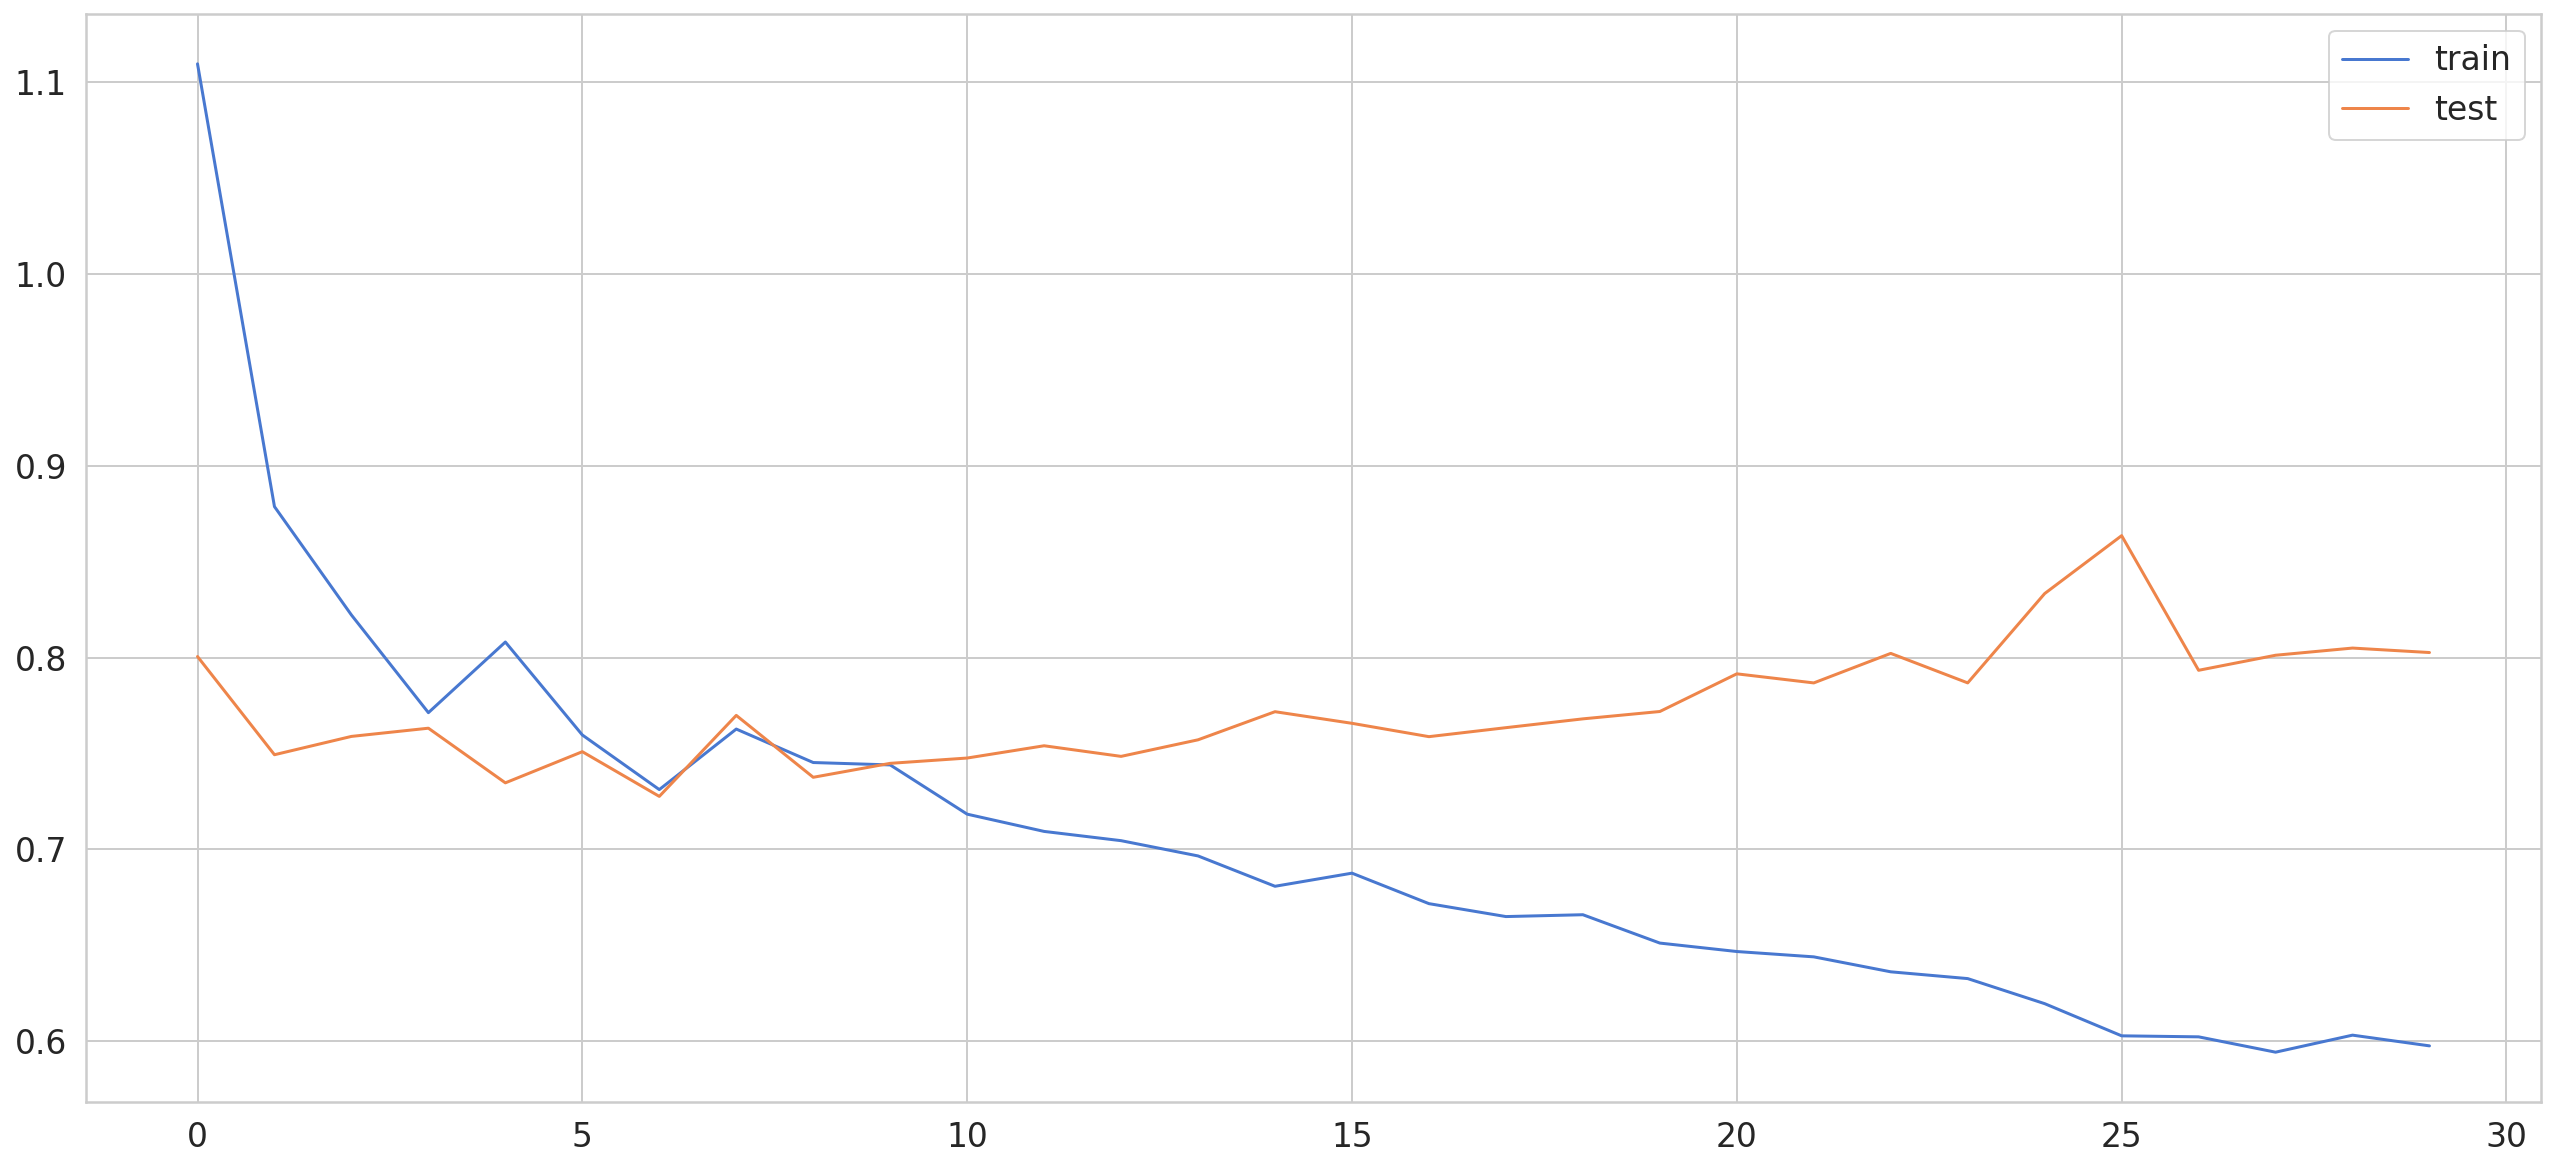

In [ ]:
plt.plot(history6.history['mae'], label='train')
plt.plot(history6.history['val_mae'], label='test')
plt.legend();

# Visualizing All Model Loss

## RSME

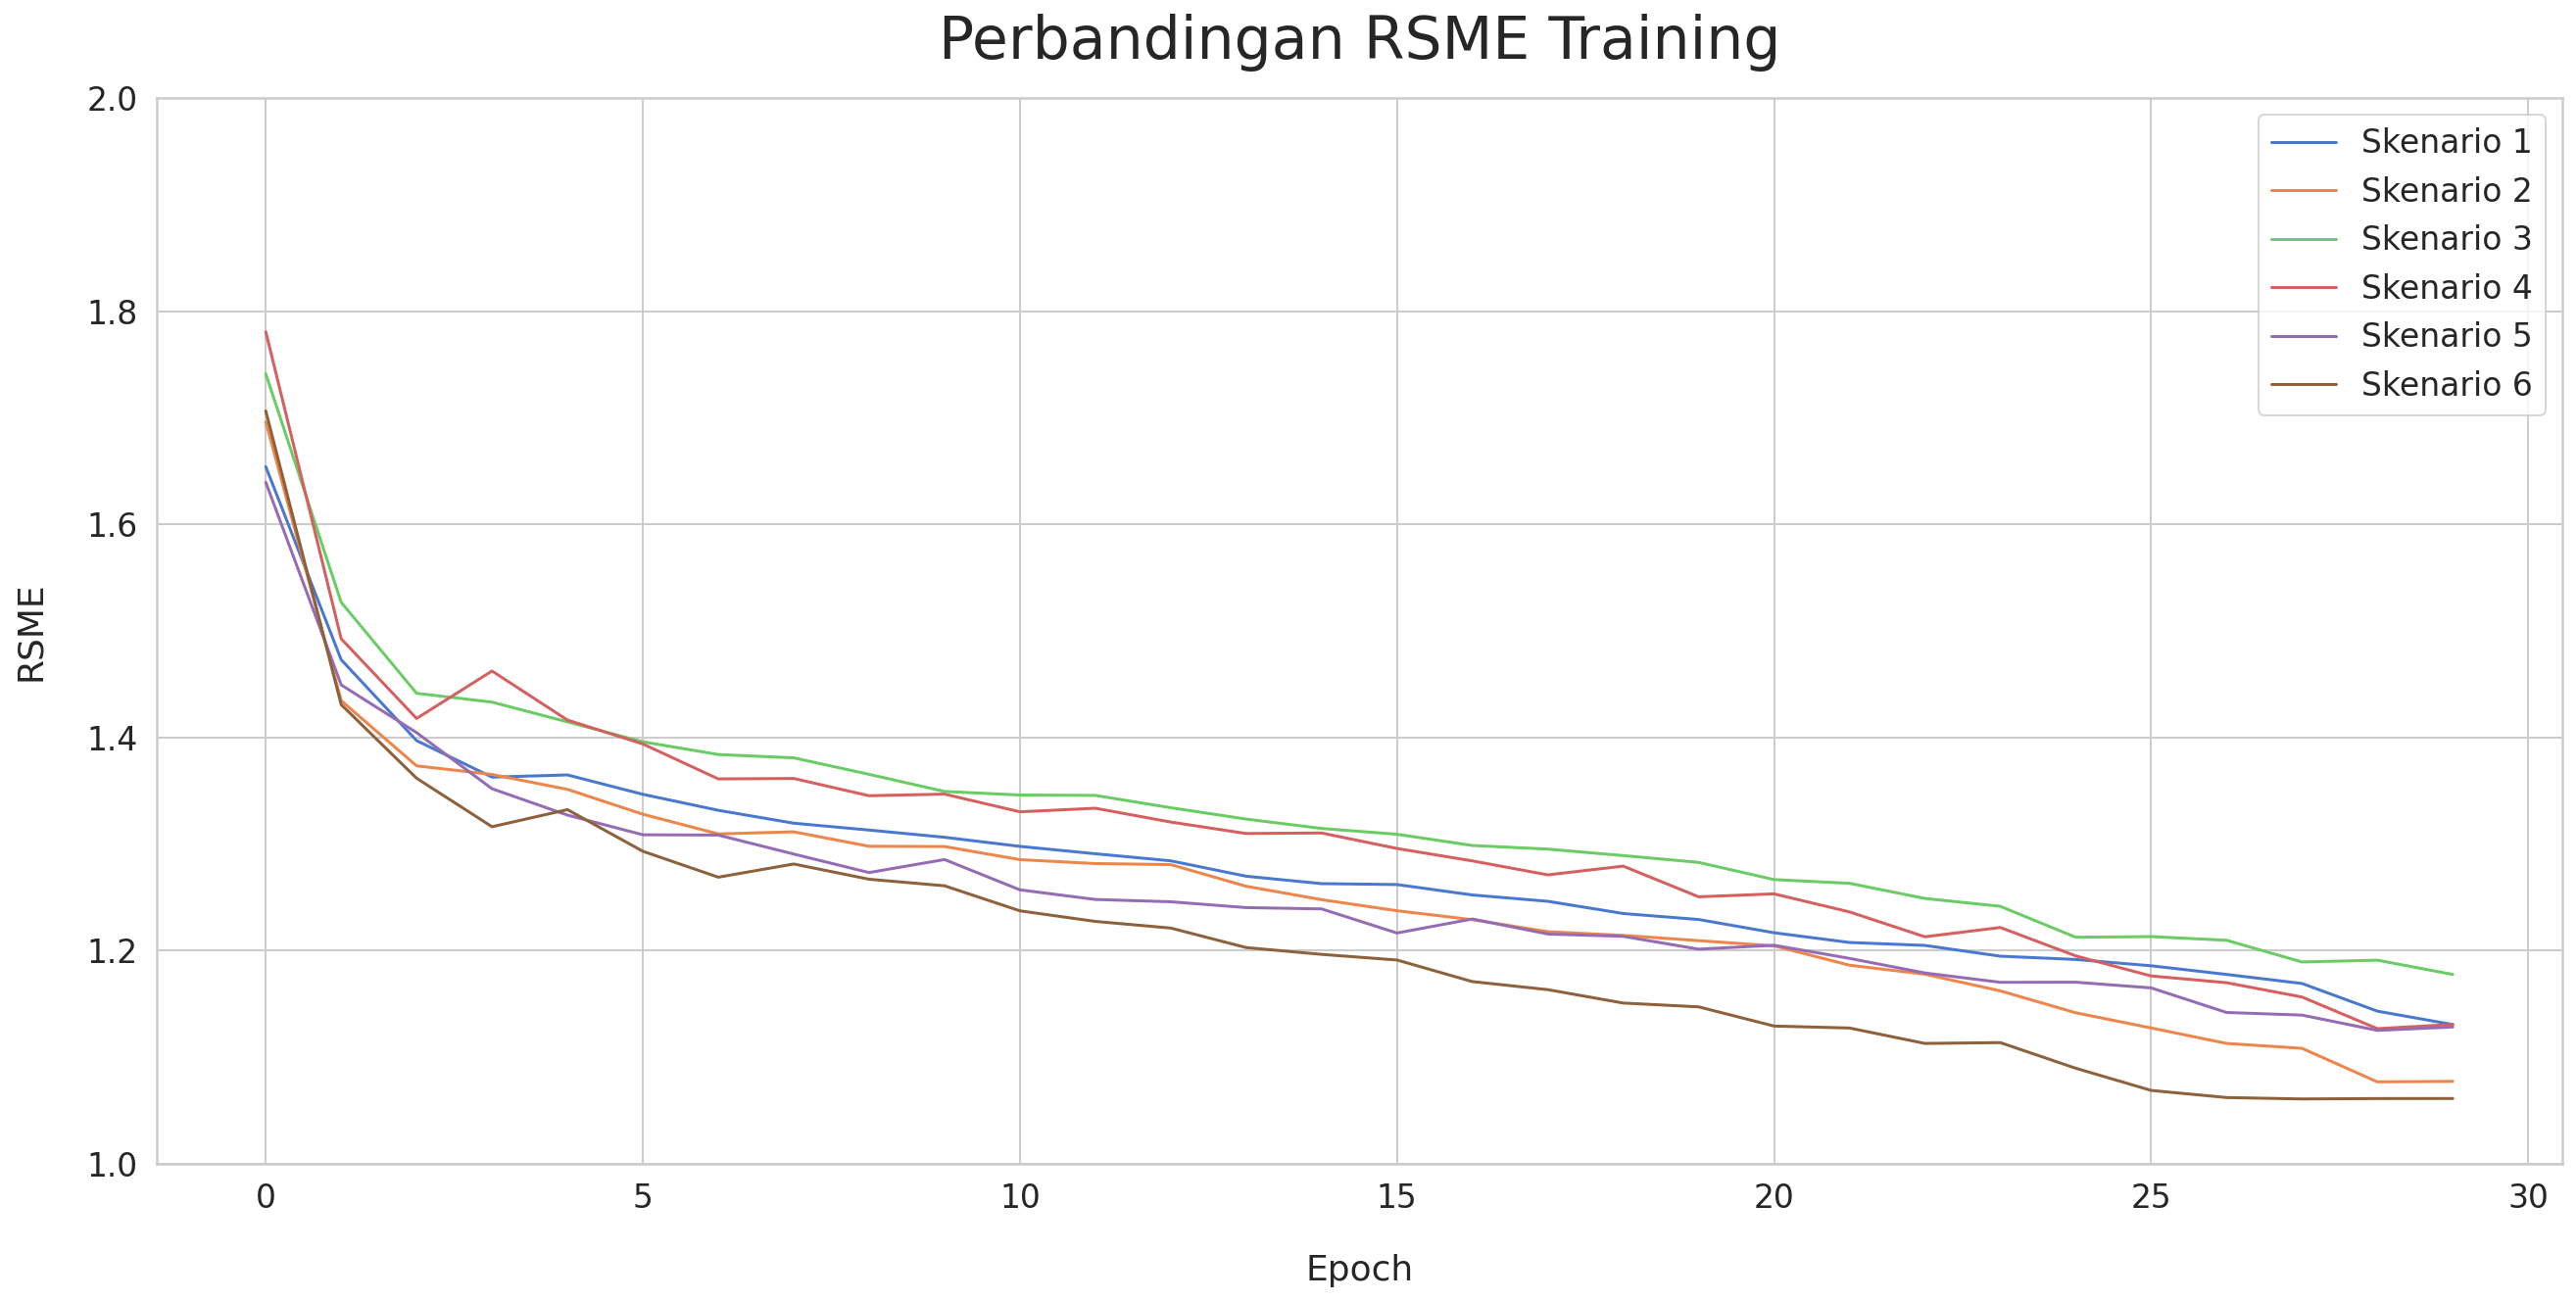

In [ ]:
plt.plot(history.history['loss'], label='Skenario 1')
plt.plot(history2.history['loss'], label='Skenario 2')
plt.plot(history3.history['loss'], label='Skenario 3')
plt.plot(history4.history['loss'], label='Skenario 4')
plt.plot(history5.history['loss'], label='Skenario 5')
plt.plot(history6.history['loss'], label='Skenario 6')
plt.ylabel('RSME')
plt.xlabel('Epoch')
plt.title('Perbandingan RSME Training',fontsize=30)
plt.ylim(1,2)
plt.legend();


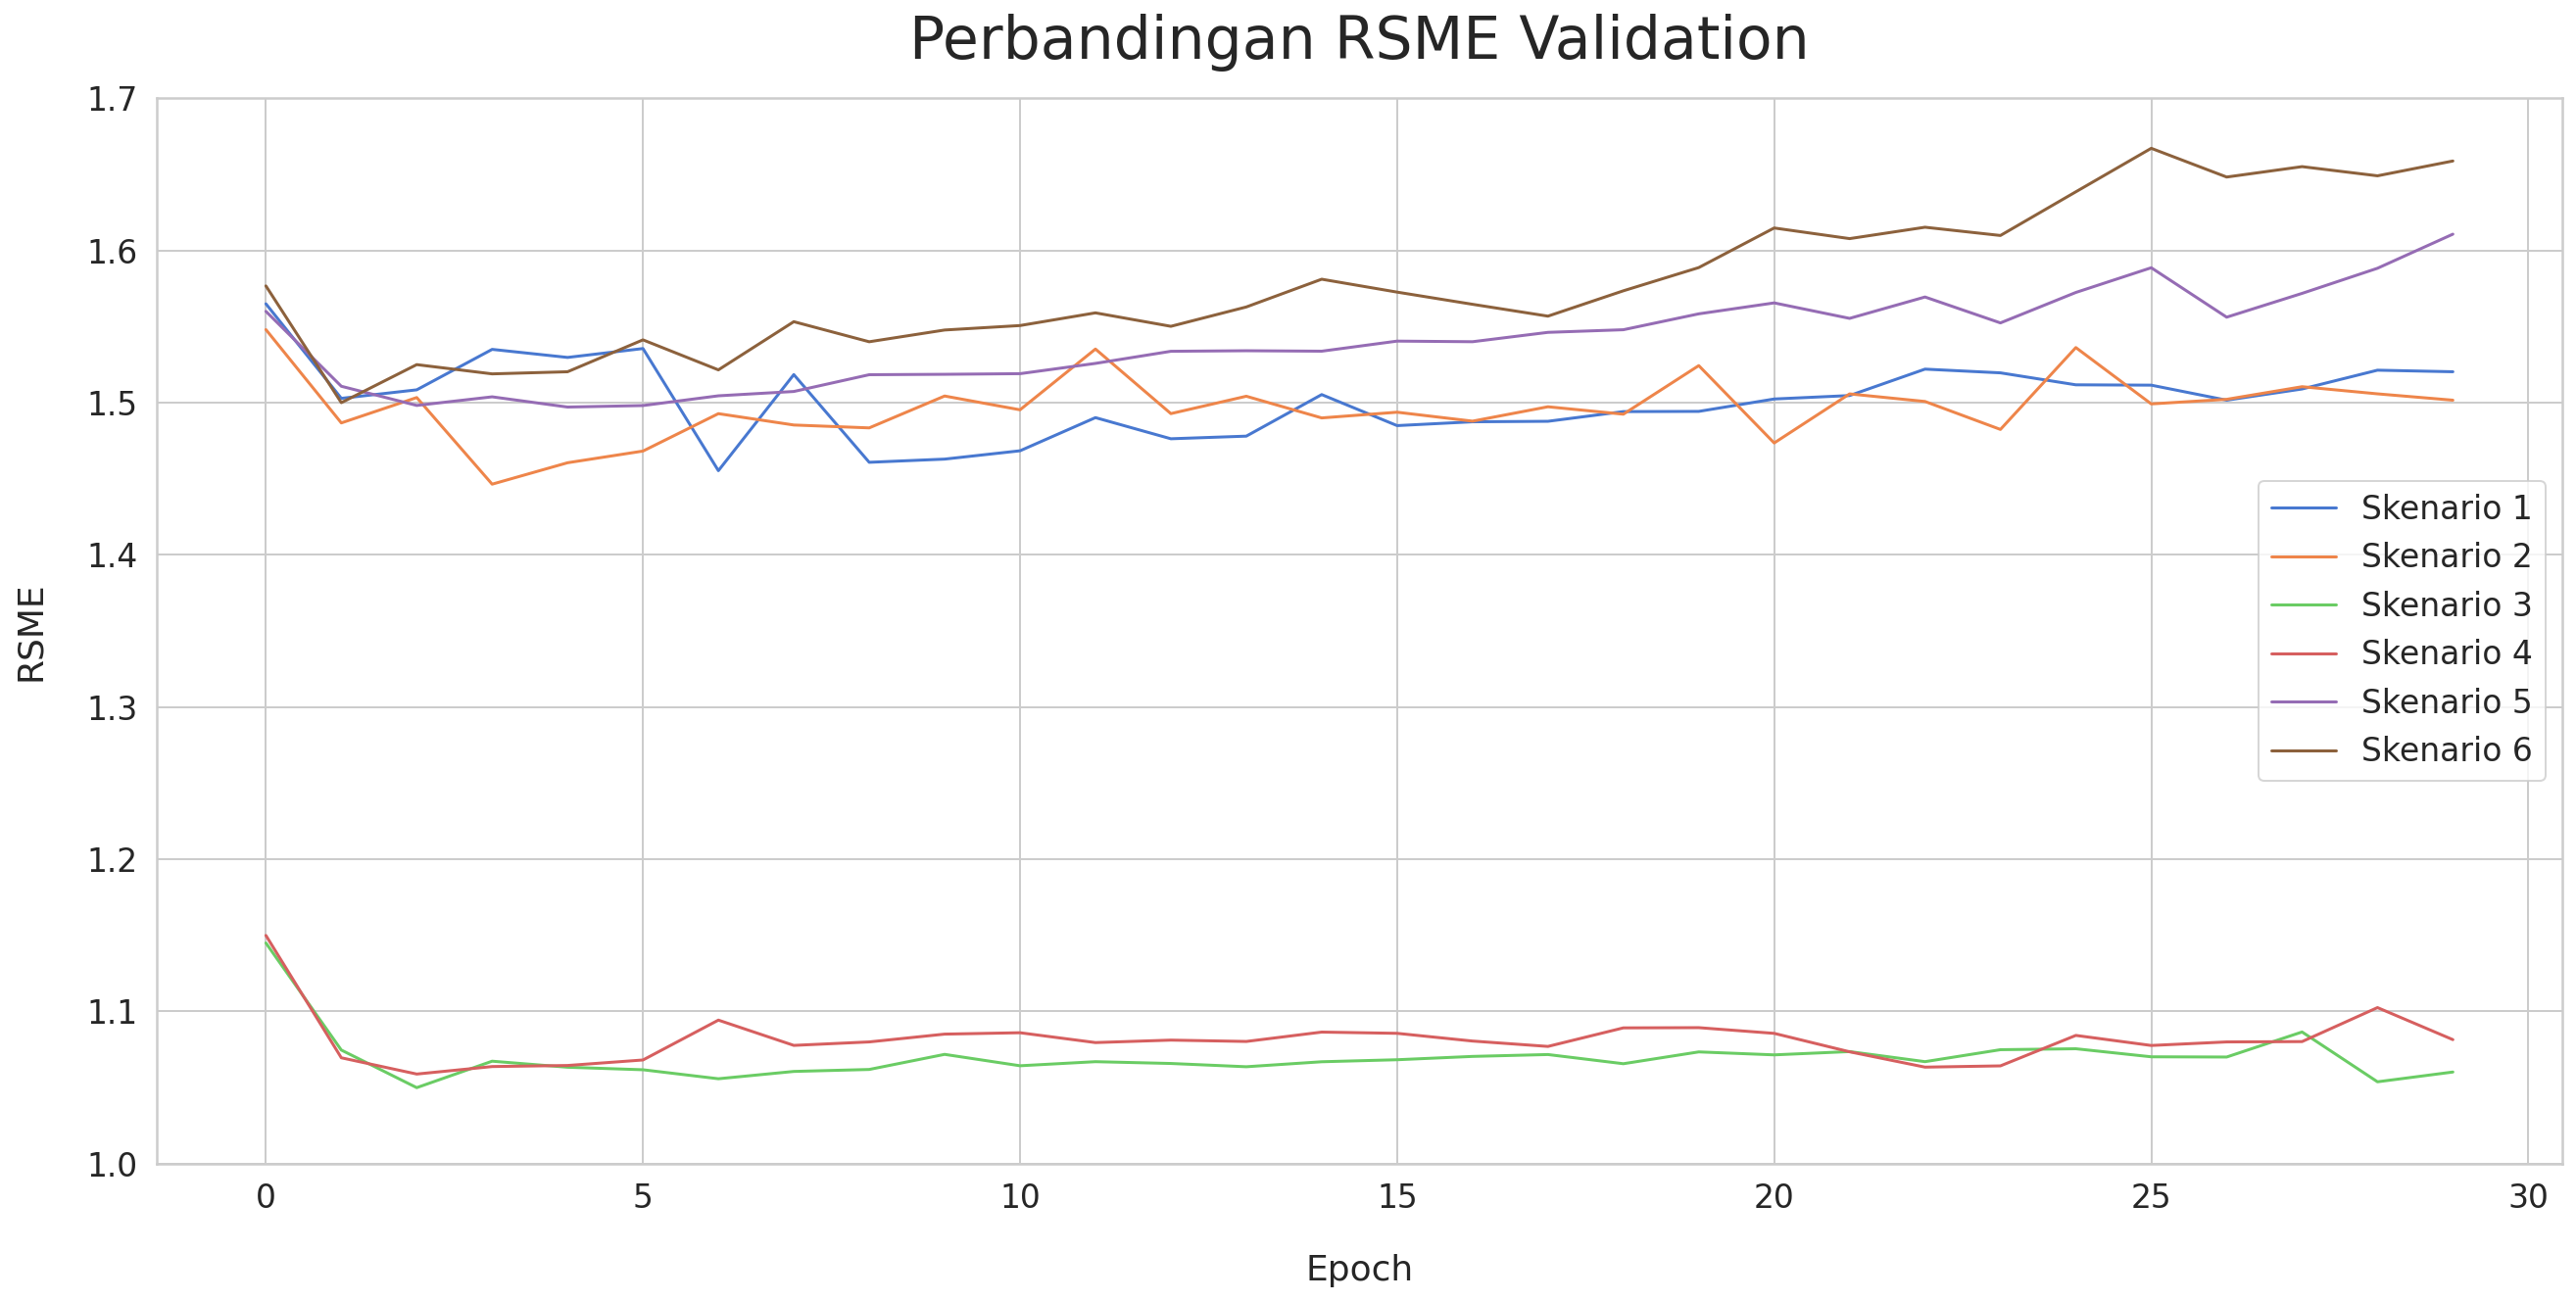

In [ ]:
plt.plot(history.history['val_loss'], label='Skenario 1')
plt.plot(history2.history['val_loss'], label='Skenario 2')
plt.plot(history3.history['val_loss'], label='Skenario 3')
plt.plot(history4.history['val_loss'], label='Skenario 4')
plt.plot(history5.history['val_loss'], label='Skenario 5')
plt.plot(history6.history['val_loss'], label='Skenario 6')
plt.ylabel('RSME')
plt.xlabel('Epoch')
plt.title('Perbandingan RSME Validation',fontsize=30)
plt.ylim(1,1.7)
plt.legend();


## MAE

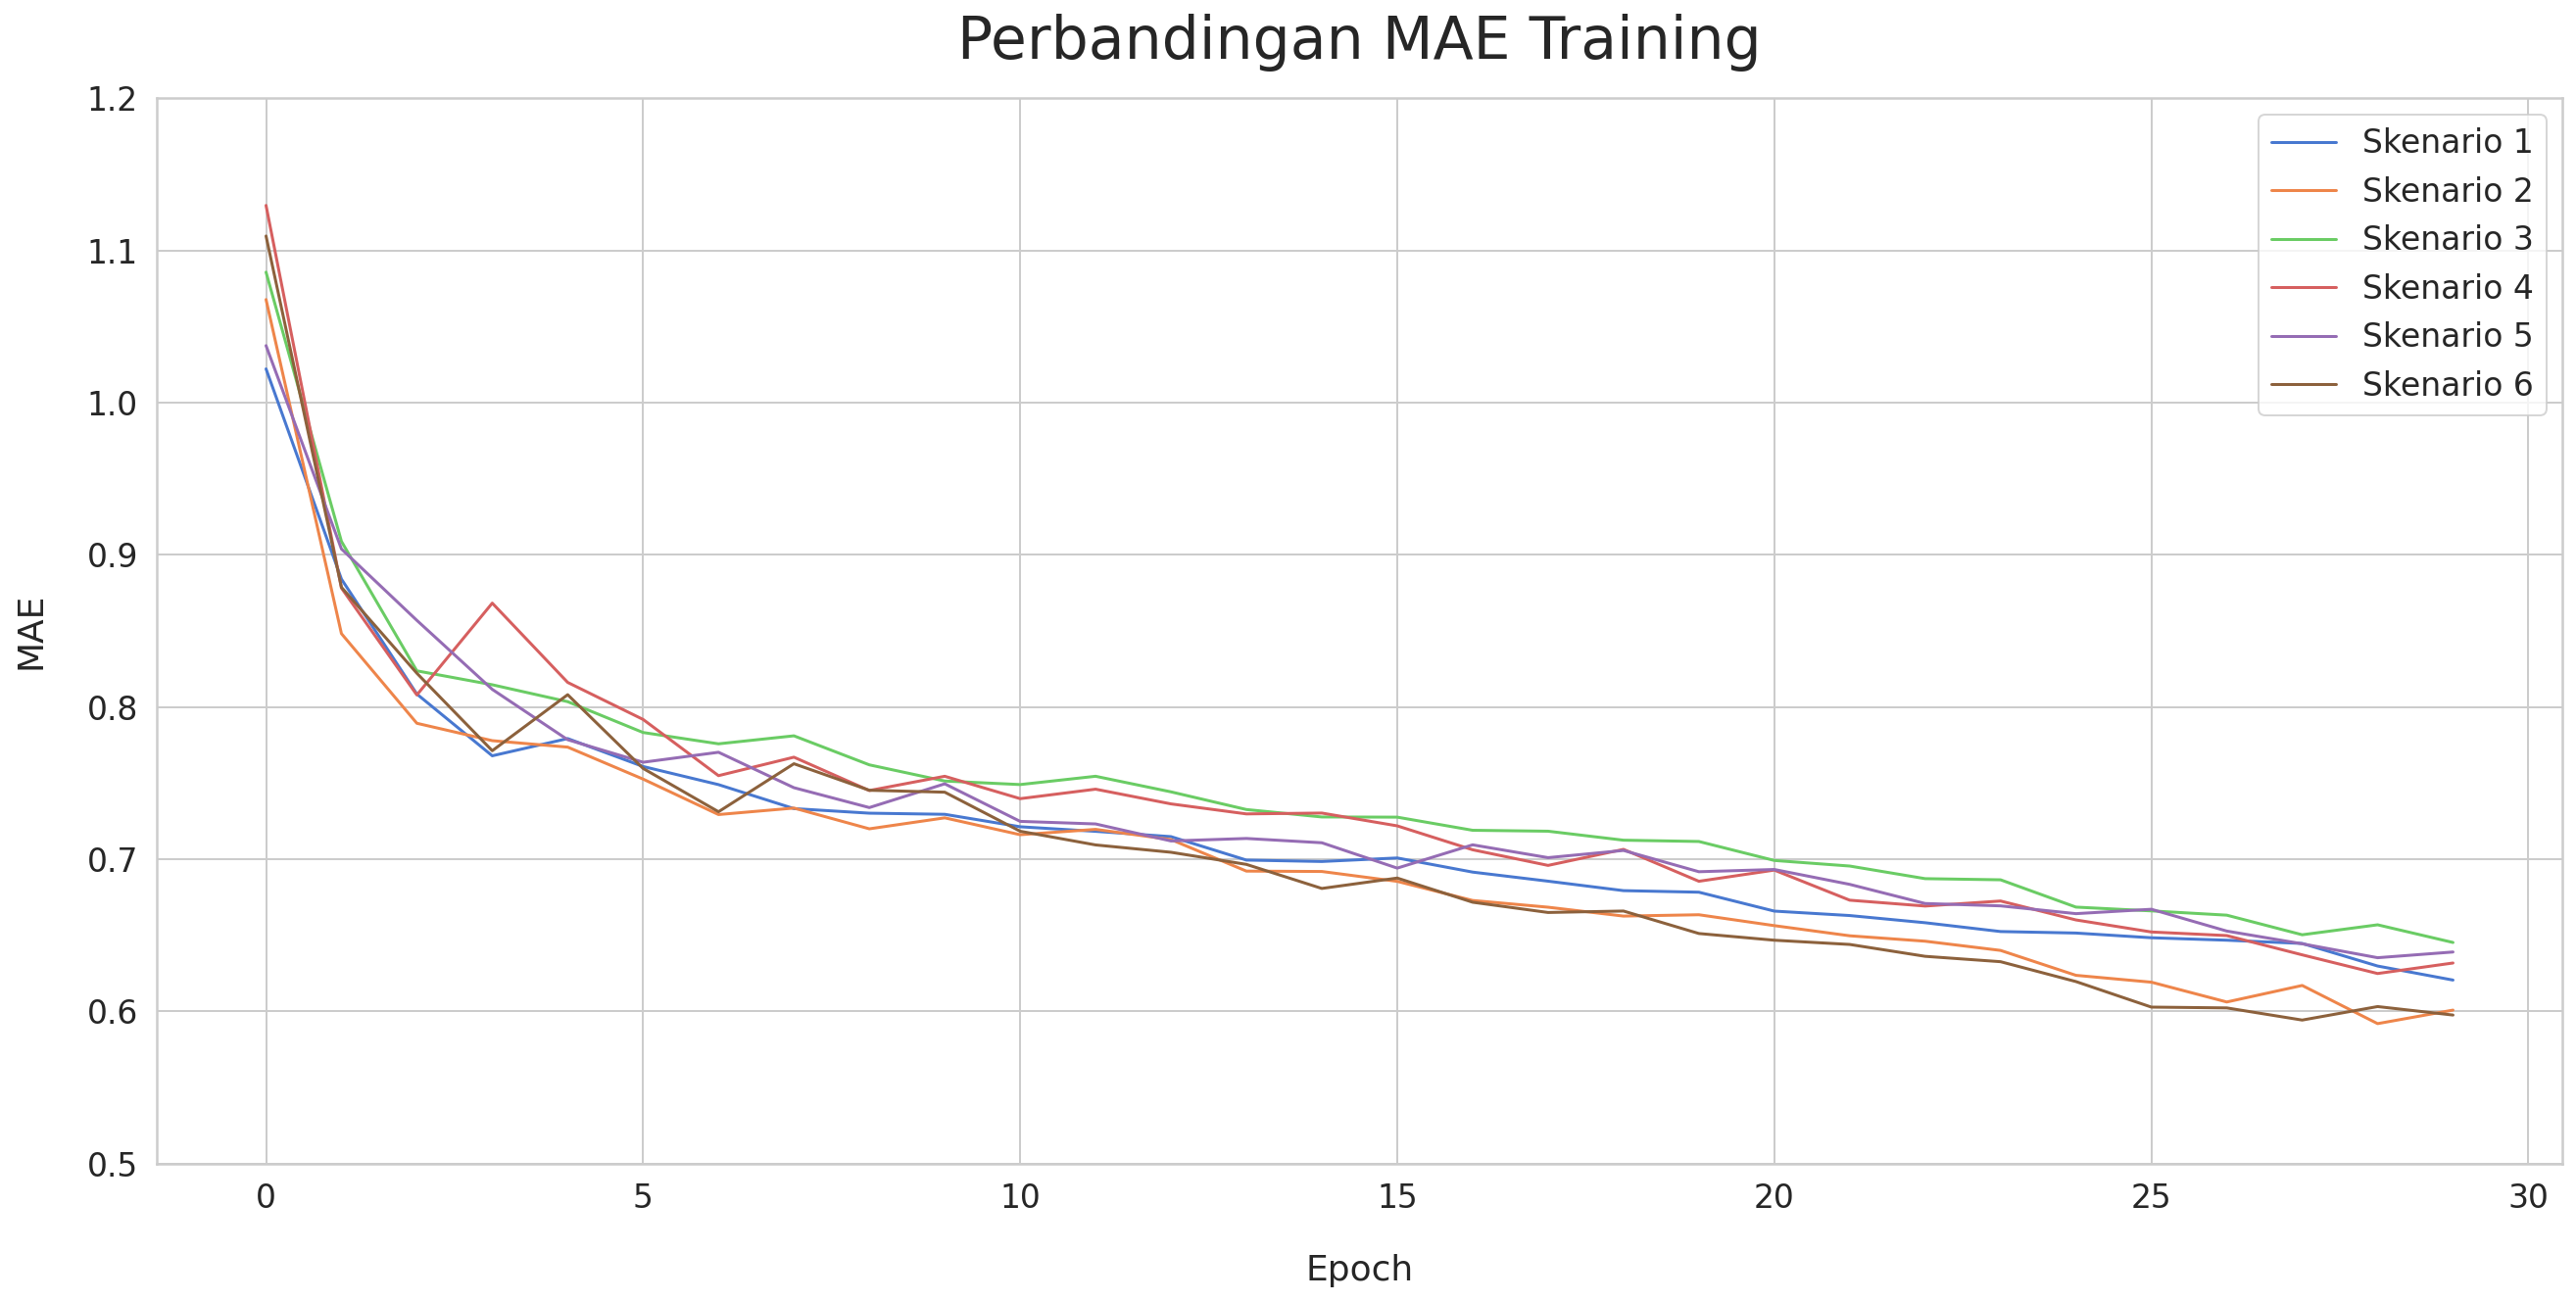

In [ ]:
plt.plot(history.history['mae'], label='Skenario 1')
plt.plot(history2.history['mae'], label='Skenario 2')
plt.plot(history3.history['mae'], label='Skenario 3')
plt.plot(history4.history['mae'], label='Skenario 4')
plt.plot(history5.history['mae'], label='Skenario 5')
plt.plot(history6.history['mae'], label='Skenario 6')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.ylim(0.5,1.2)
plt.title('Perbandingan MAE Training',fontsize=30)
plt.legend();


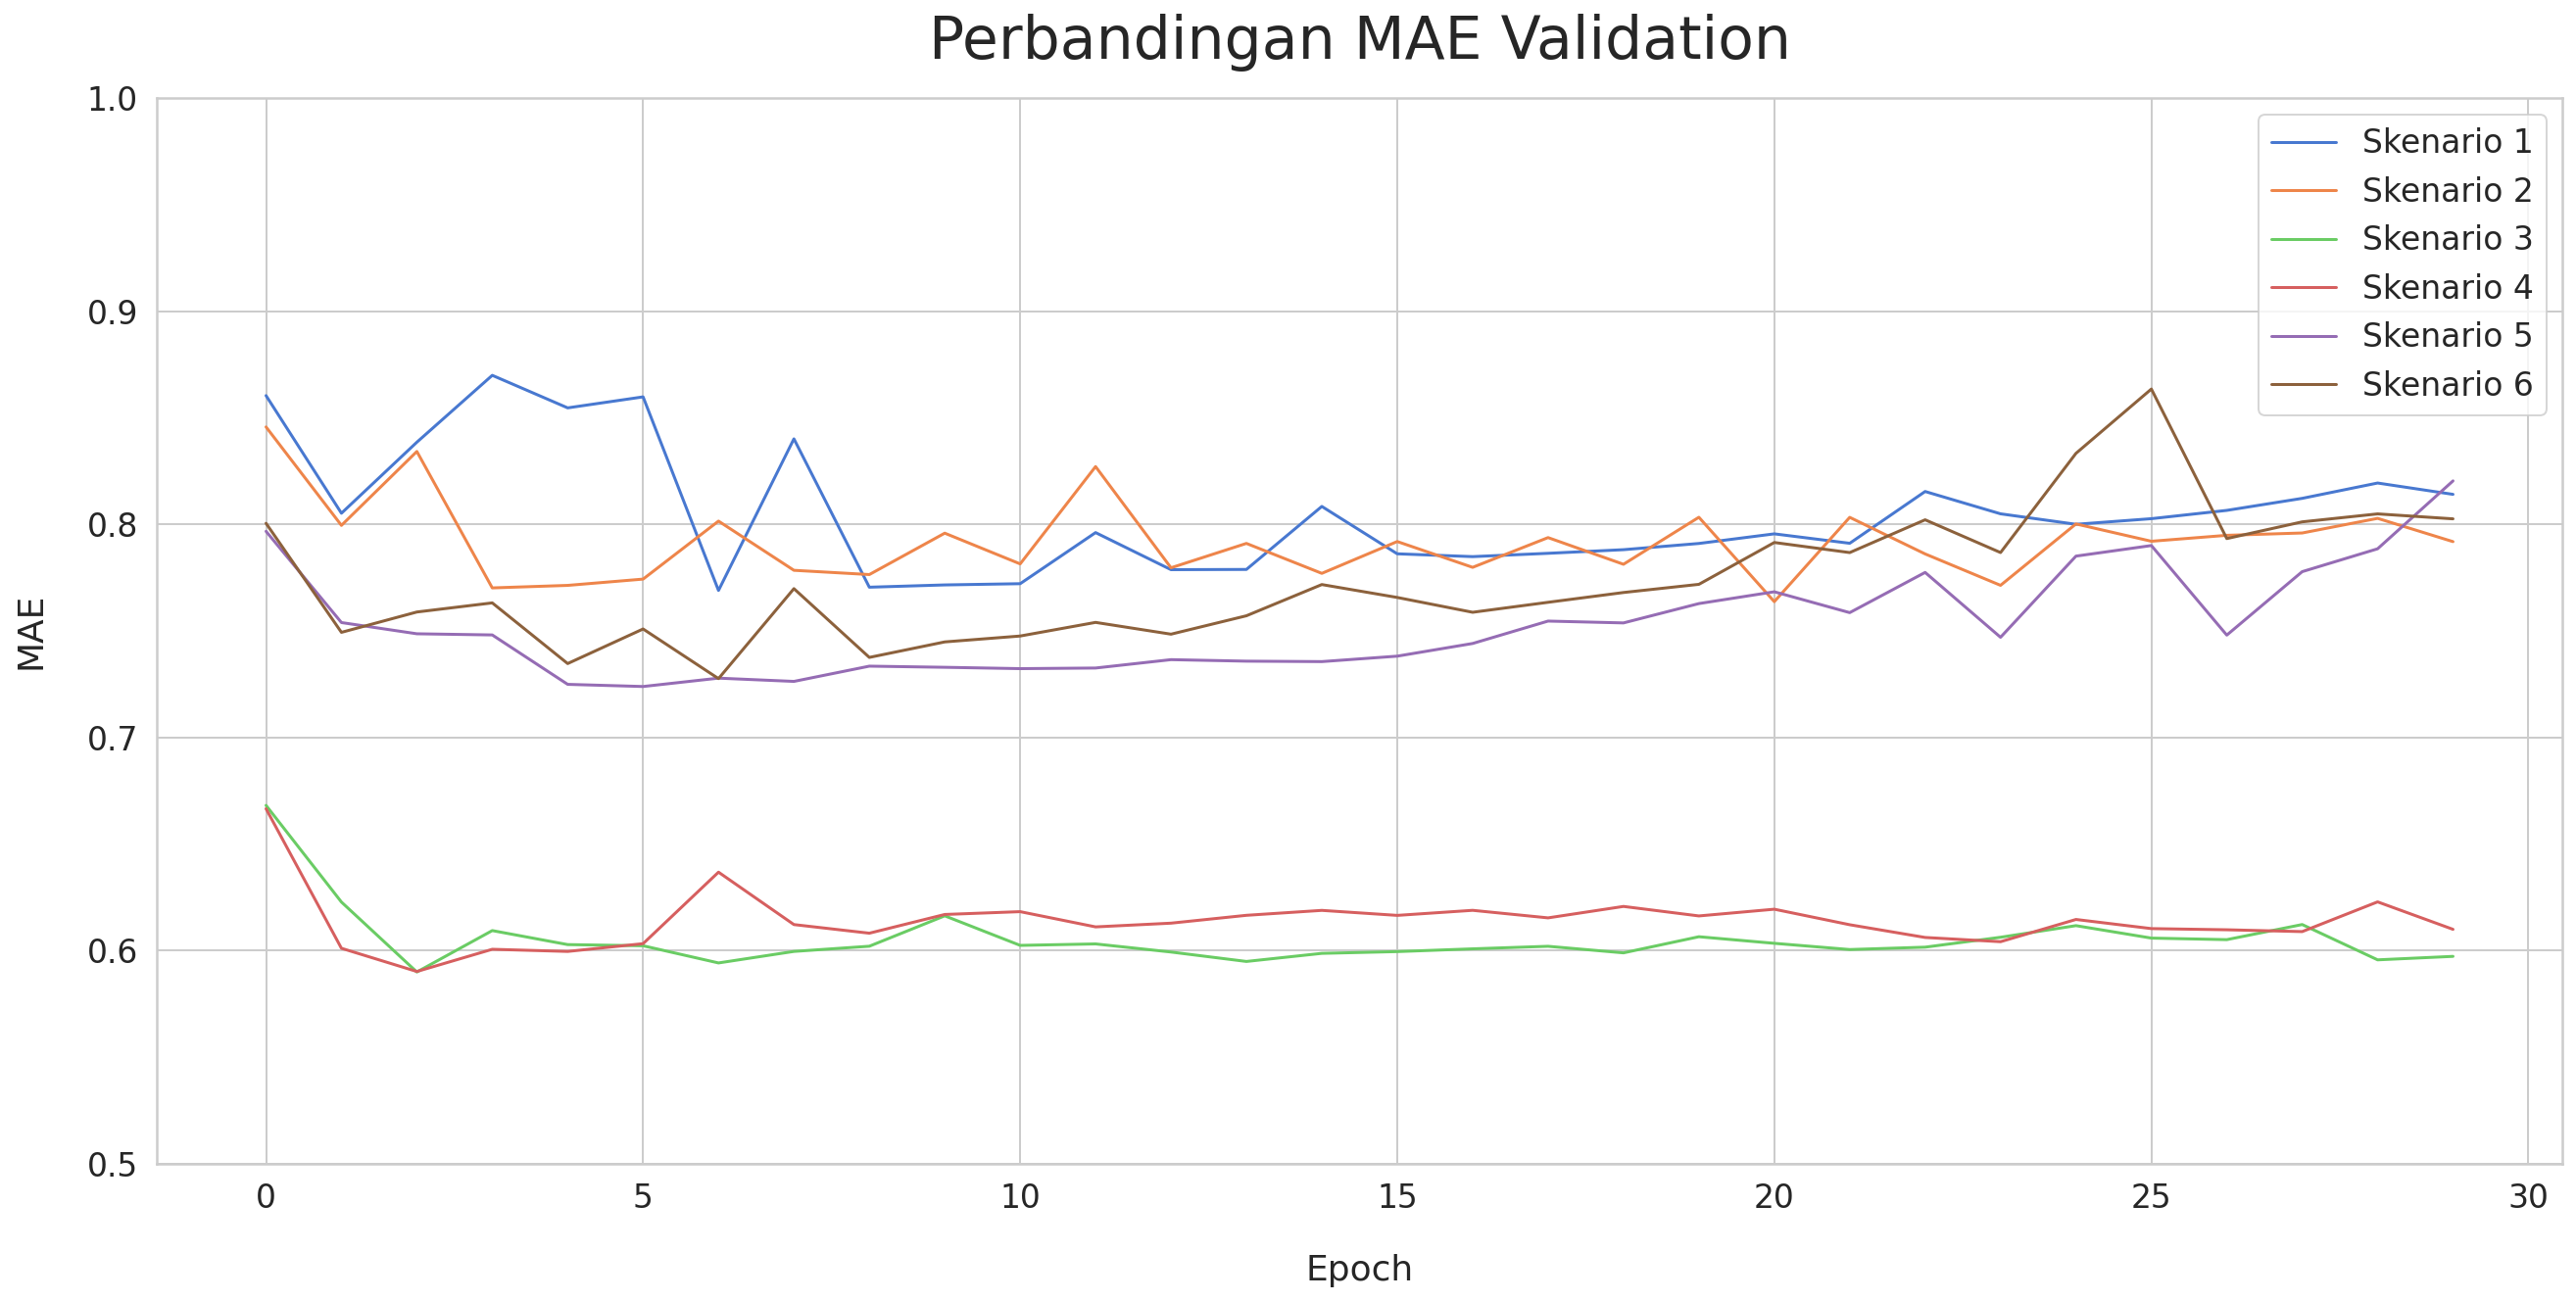

In [ ]:
plt.plot(history.history['val_mae'], label='Skenario 1')
plt.plot(history2.history['val_mae'], label='Skenario 2')
plt.plot(history3.history['val_mae'], label='Skenario 3')
plt.plot(history4.history['val_mae'], label='Skenario 4')
plt.plot(history5.history['val_mae'], label='Skenario 5')
plt.plot(history6.history['val_mae'], label='Skenario 6')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.title('Perbandingan MAE Validation',fontsize=30)
plt.ylim(0.5,1)
plt.legend();


In [ ]:
print(history6.history['loss'][-1])

1.0609675645828247


In [ ]:
rsme_train=[]
rsme_train.append(history.history['loss'][-1])
rsme_train.append(history2.history['loss'][-1])
rsme_train.append(history3.history['loss'][-1])
rsme_train.append(history4.history['loss'][-1])
rsme_train.append(history5.history['loss'][-1])
rsme_train.append(history6.history['loss'][-1])

mae_train=[]
mae_train.append(history.history['mae'][-1])
mae_train.append(history2.history['mae'][-1])
mae_train.append(history3.history['mae'][-1])
mae_train.append(history4.history['mae'][-1])
mae_train.append(history5.history['mae'][-1])
mae_train.append(history6.history['mae'][-1])


In [ ]:
rsme_val=[]
rsme_val.append(history.history['val_loss'][-1])
rsme_val.append(history2.history['val_loss'][-1])
rsme_val.append(history3.history['val_loss'][-1])
rsme_val.append(history4.history['val_loss'][-1])
rsme_val.append(history5.history['val_loss'][-1])
rsme_val.append(history6.history['val_loss'][-1])

mae_val=[]
mae_val.append(history.history['val_mae'][-1])
mae_val.append(history2.history['val_mae'][-1])
mae_val.append(history3.history['val_mae'][-1])
mae_val.append(history4.history['val_mae'][-1])
mae_val.append(history5.history['val_mae'][-1])
mae_val.append(history6.history['val_mae'][-1])

## Tabel Perbandingan

In [ ]:
perbandingan_df = pd.DataFrame({
    'Skenario':[1,2,3,4,5,6],
    'Training RSME':rsme_train,
    'Training MAE':mae_train,
    'Validation RSME':rsme_val,
    'Validation MAE':mae_val
})
perbandingan_df

,Skenario,Training RSME,Training MAE,Validation RSME,Validation MAE
0,1,1.130414,0.620519,1.520321,0.814101
1,2,1.077097,0.600792,1.501633,0.791903
2,3,1.177470,0.645224,1.060095,0.597219
3,4,1.130533,0.631745,1.081364,0.609903
4,5,1.128123,0.638980,1.610755,0.820430
5,6,1.060968,0.597526,1.658839,0.802608


dari tabel diatas, yg rsme valid sama mae valid nya paling kecil itu skenario 3

# Predicting the value

In [ ]:
y_pred = model3.predict(X_test)

## Denormalize

In [ ]:
y_train_inv = cnt_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cnt_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cnt_transformer.inverse_transform(y_pred)

In [ ]:
print(y_pred_inv.shape)

(644, 1)


In [ ]:
for_future_date = df_date['Date'].iloc[-len(y_pred_inv.flatten()):]
for_future_date = np.array(for_future_date)

In [ ]:
forecast_period_dates = pd.date_range(for_future_date[0], periods=len(y_pred_inv.flatten()), freq='1d').tolist()

In [ ]:
forecast_dates = []
for time_i in forecast_period_dates:
    forecast_dates.append(time_i)

In [ ]:
forecast_dates

[Timestamp('2019-03-29 00:00:00', freq='D'),
 Timestamp('2019-03-30 00:00:00', freq='D'),
 Timestamp('2019-03-31 00:00:00', freq='D'),
 Timestamp('2019-04-01 00:00:00', freq='D'),
 Timestamp('2019-04-02 00:00:00', freq='D'),
 Timestamp('2019-04-03 00:00:00', freq='D'),
 Timestamp('2019-04-04 00:00:00', freq='D'),
 Timestamp('2019-04-05 00:00:00', freq='D'),
 Timestamp('2019-04-06 00:00:00', freq='D'),
 Timestamp('2019-04-07 00:00:00', freq='D'),
 Timestamp('2019-04-08 00:00:00', freq='D'),
 Timestamp('2019-04-09 00:00:00', freq='D'),
 Timestamp('2019-04-10 00:00:00', freq='D'),
 Timestamp('2019-04-11 00:00:00', freq='D'),
 Timestamp('2019-04-12 00:00:00', freq='D'),
 Timestamp('2019-04-13 00:00:00', freq='D'),
 Timestamp('2019-04-14 00:00:00', freq='D'),
 Timestamp('2019-04-15 00:00:00', freq='D'),
 Timestamp('2019-04-16 00:00:00', freq='D'),
 Timestamp('2019-04-17 00:00:00', freq='D'),
 Timestamp('2019-04-18 00:00:00', freq='D'),
 Timestamp('2019-04-19 00:00:00', freq='D'),
 Timestamp

In [ ]:
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Chl_a':abs(y_pred_inv.flatten())})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

df_true = pd.DataFrame({'Date':np.array(forecast_dates), 'Chl_a':abs(y_test_inv.flatten())})
df_true['Date'] = pd.to_datetime(df_true['Date'])

In [ ]:
history_date = df_date['Date'].iloc[:-len(y_pred_inv.flatten())]
history_date = pd.to_datetime(history_date)

history_df = pd.DataFrame({'Date':np.array(history_date),
                           'Chl_a':np.array(df['Chl_a'].iloc[:-len(y_pred_inv.flatten())])
                           })

# Visualizing

Text(0.5, 1.0, 'Pembagian Komposisi Data dengan Skenario 3')

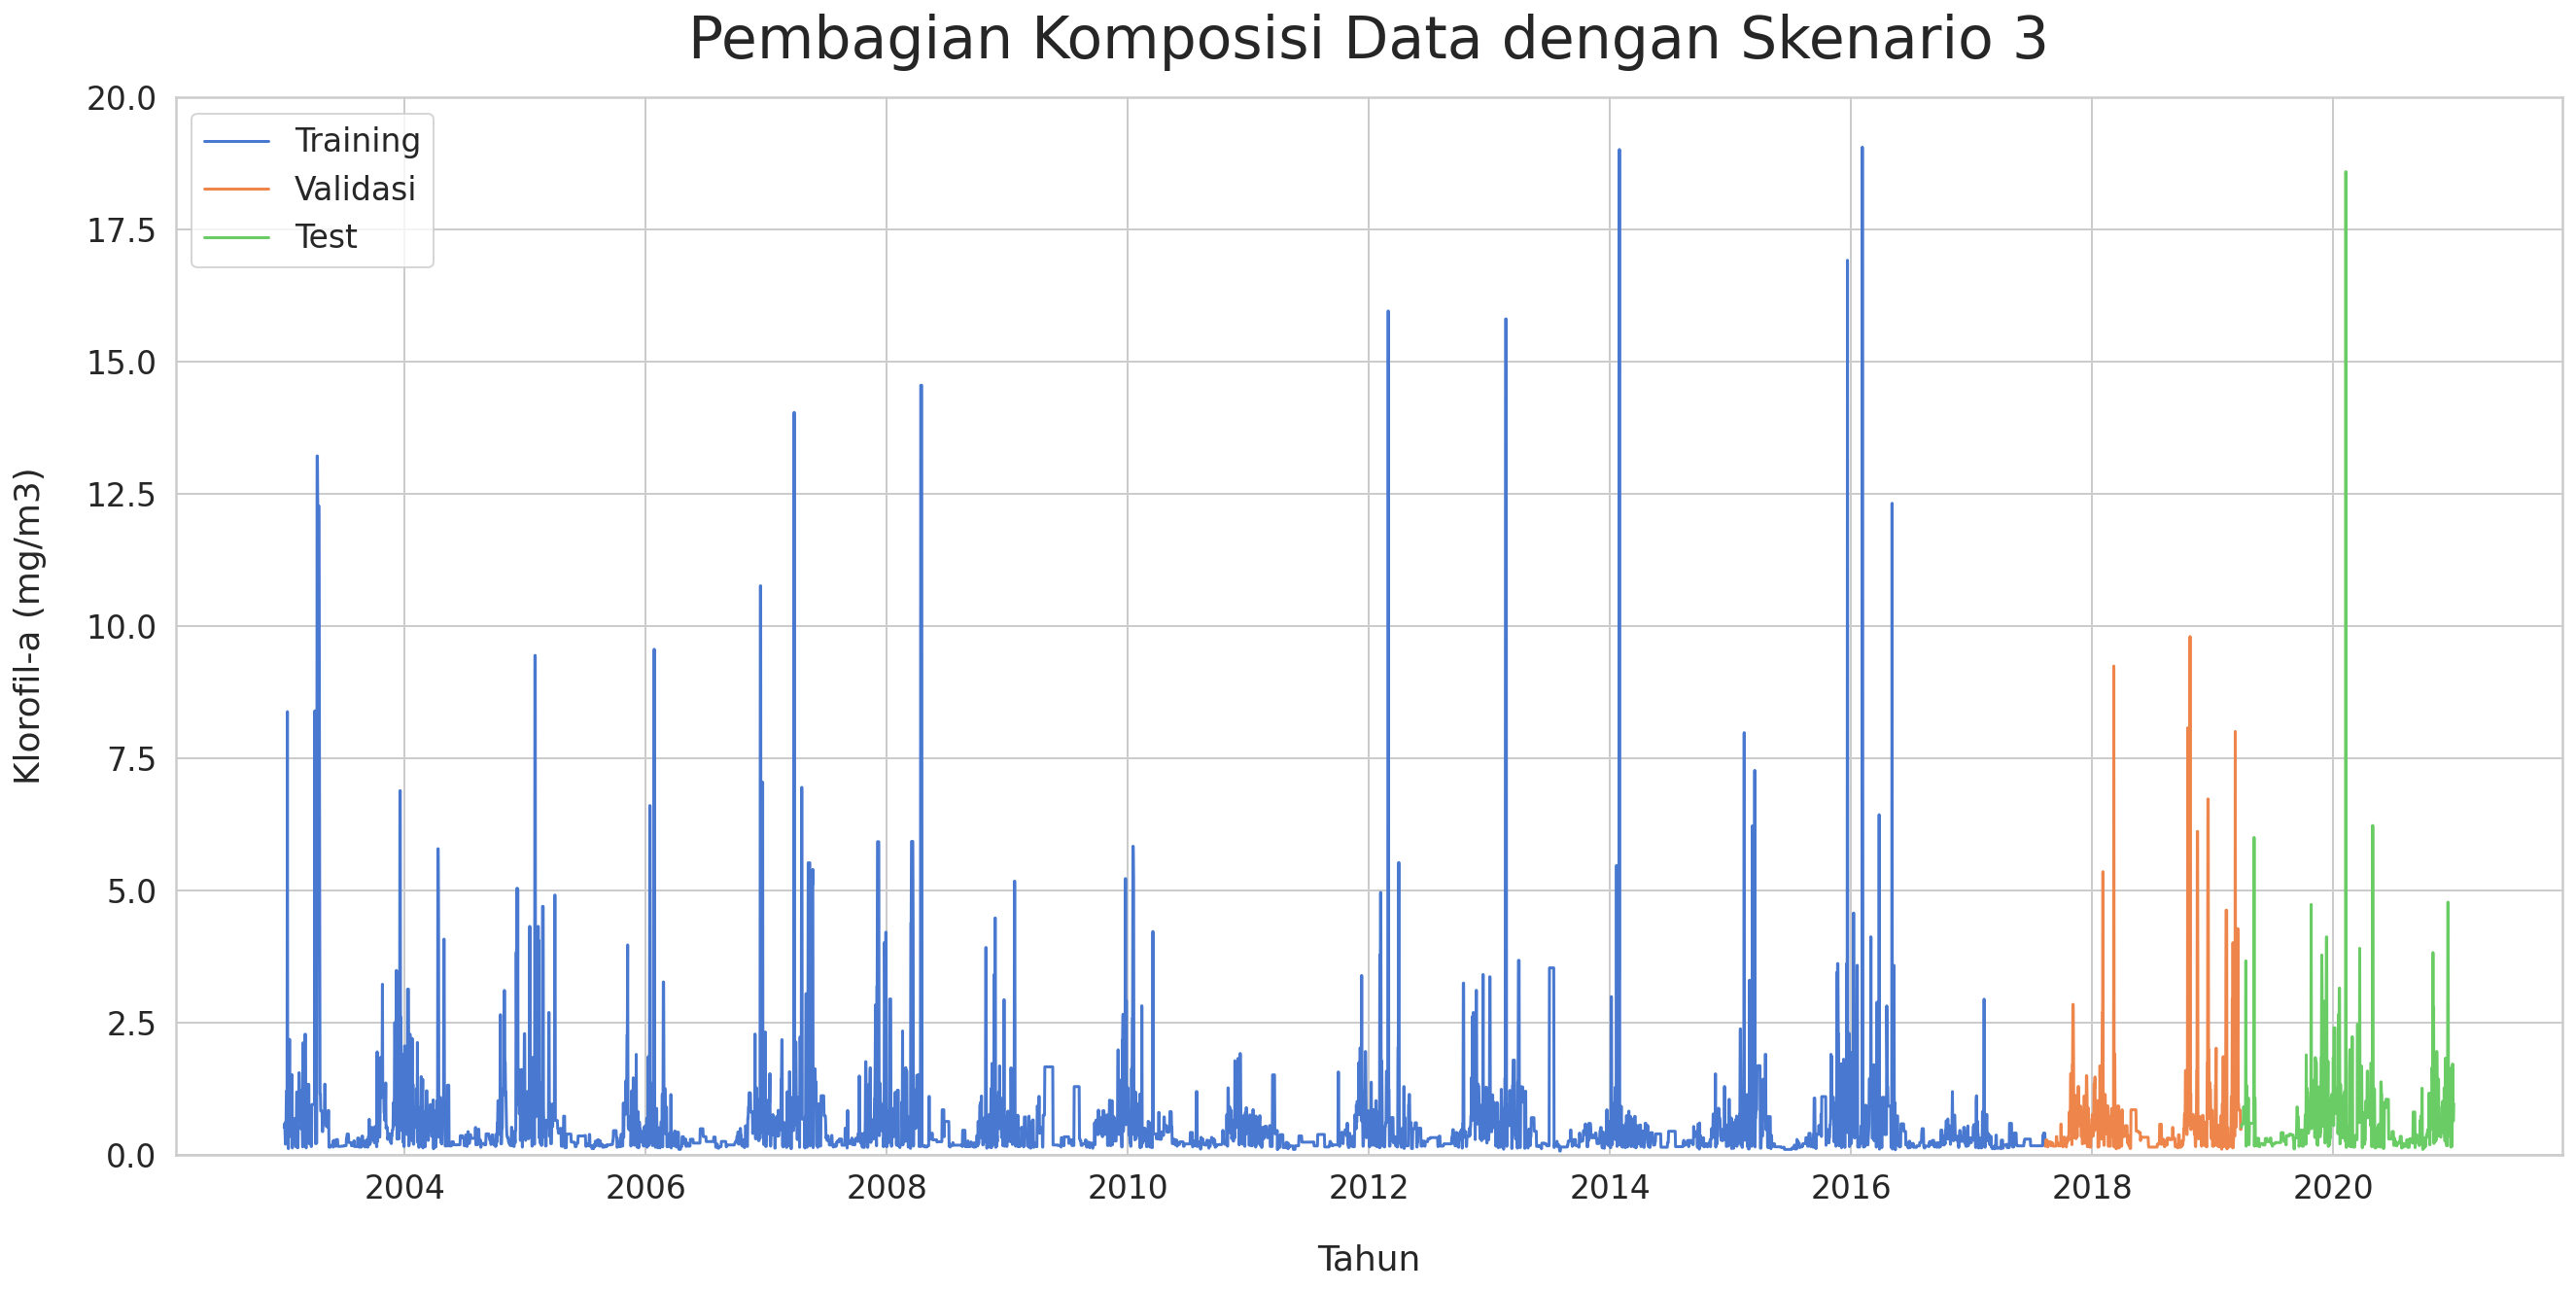

In [ ]:
sns.lineplot(x = history_df['Date'][:int(len(history_df)*0.9)], y = history_df['Chl_a'], label='Training')
sns.lineplot(x = history_df['Date'][int(len(history_df)*0.9):], y = history_df['Chl_a'], label='Validasi')
sns.lineplot(x = df_true['Date'], y = df_true['Chl_a'], label='Test')
#sns.lineplot(x = df_forecast['Date'], y = df_forecast['Chl_a'], label='Prediksi')
plt.xlabel('Tahun')
plt.ylabel('Klorofil-a (mg/m3)')
plt.ylim(0,20)
plt.legend()
plt.title('Pembagian Komposisi Data dengan Skenario 3',fontsize=30)

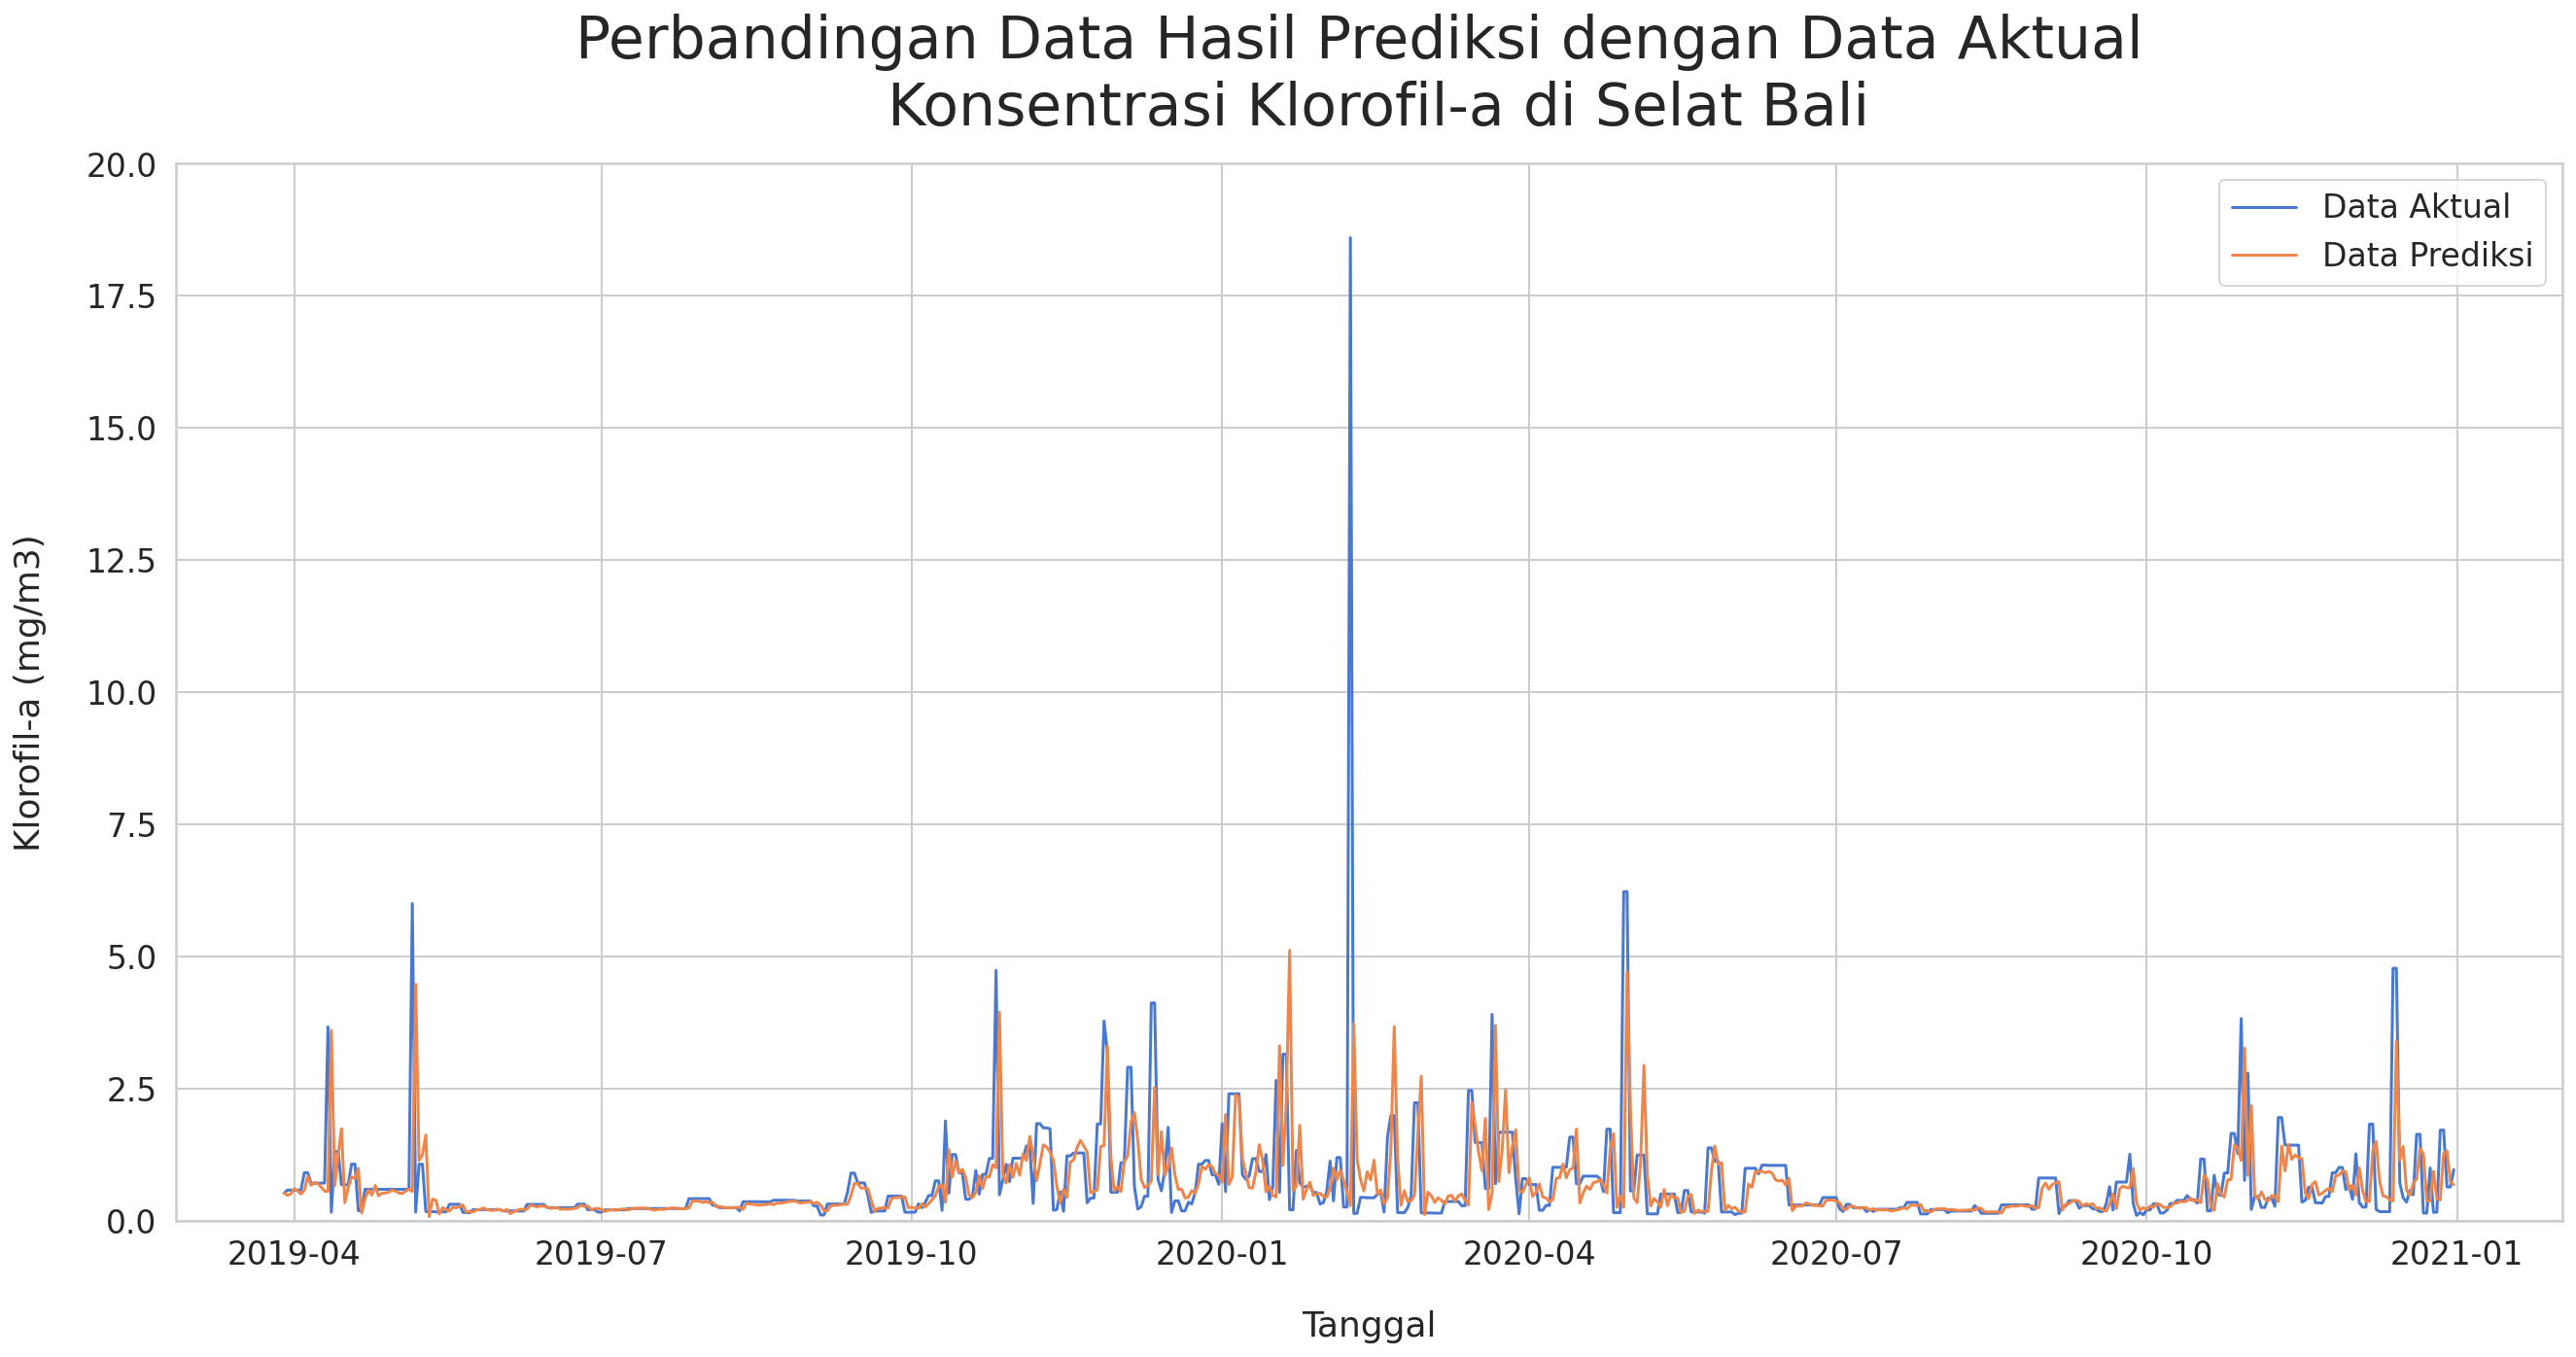

In [ ]:
sns.lineplot(x = df_true['Date'], y = df_true['Chl_a'], label='Data Aktual')
sns.lineplot(x = df_forecast['Date'], y = df_forecast['Chl_a'], label='Data Prediksi')
plt.xlabel('Tanggal')
plt.ylabel('Klorofil-a (mg/m3)')
plt.ylim(0,20)
plt.title('Perbandingan Data Hasil Prediksi dengan Data Aktual \n Konsentrasi Klorofil-a di Selat Bali',fontsize=30)
plt.legend()

# Export Hasil Prediksi dan Perbandingan Skenario

In [ ]:
final_pd = pd.DataFrame({
    'Date':df_true['Date'],
    'Actual_Chl_a':df_true['Chl_a'],
    'Predicted_Chl_a':df_forecast['Chl_a']
})

In [ ]:
final_pd

In [ ]:
final_pd.to_csv('Hasil Peramalan Klorofil - a di Selat Bali dengan LSTM.csv')
perbandingan_df.to_csv('Tabel Perbandingan Skenario LSTM.csv')